# Projet - Analyse explo

In [3]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(repr)
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attachement du package : ‘gridExtra’


L'objet suivant est masqué depuis ‘package:dplyr’:

    combine


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attachement du package : ‘plotly’


L'objet suivant est masqué depuis ‘package:ggplot2’:

    last_plot


L'objet suivant est masqué depuis ‘package:stats’:

    filter


L'objet suivant est masqué depuis ‘package:graphics’:

    layout


corrplot 0.94 loaded


Attachement 

In [4]:
set.seed(1234)

In [5]:
options(repr.plot.width=15, repr.plot.height=8)

## GRAPH SETTINGS ##
# Save original parameters (optional)
original_par <- par(no.readonly = TRUE)

# Set global scaling factors (1.5x default size)
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 1.5,  # Main title
  cex.sub = 1.5    # Subtitle
)


# Define a custom theme with larger fonts
custom_theme <- theme(
  text = element_text(size = 16),            # Global text size
  axis.title = element_text(size = 18),      # Axis labels
  axis.text = element_text(size = 14),       # Axis tick labels
  plot.title = element_text(size = 20),      # Main title
  plot.subtitle = element_text(size = 16)    # Subtitle
)

# Apply the theme to all future plots
theme_set(custom_theme)

## Analyse Descriptive et Transformation des Données

### Prise en main des données

In [6]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
gym <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)
# Premières lignes du jeu de données
head(gym)
# Vérification du contenu
summary(gym)

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,BMI
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,56,Male,88.3,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,30.20
2,46,Female,74.9,1.53,179,151,66,1.30,883,HIIT,33.9,2.1,4,2,32.00
3,32,Female,68.1,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,24.71
4,25,Male,53.2,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,18.41
5,38,Male,46.1,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,14.39
6,56,Female,58.0,1.68,168,156,74,1.59,1116,HIIT,15.5,2.7,5,3,20.55


      Age           Gender           Weight..kg.       Height..m.   
 Min.   :18.00   Length:973         Min.   : 40.00   Min.   :1.500  
 1st Qu.:28.00   Class :character   1st Qu.: 58.10   1st Qu.:1.620  
 Median :40.00   Mode  :character   Median : 70.00   Median :1.710  
 Mean   :38.68                      Mean   : 73.85   Mean   :1.723  
 3rd Qu.:49.00                      3rd Qu.: 86.00   3rd Qu.:1.800  
 Max.   :59.00                      Max.   :129.90   Max.   :2.000  
    Max_BPM         Avg_BPM       Resting_BPM    Session_Duration..hours.
 Min.   :160.0   Min.   :120.0   Min.   :50.00   Min.   :0.500           
 1st Qu.:170.0   1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040           
 Median :180.0   Median :143.0   Median :62.00   Median :1.260           
 Mean   :179.9   Mean   :143.8   Mean   :62.22   Mean   :1.256           
 3rd Qu.:190.0   3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460           
 Max.   :199.0   Max.   :169.0   Max.   :74.00   Max.   :2.000           

Ce jeu de données fournit un aperçu détaillé des routines d’exercice, des attributs physiques et des mesures
de la condition physique des membres d’une salle de sport. Il contient 15 variables observées chez 973 individus
fréquentant une salle de sport:
- `Age` : âge du membre de la salle de sport.
- `Gender` : Sexe du membre de la salle de sport (qualitative à deux modalités : homme ou femme).
- `Weight..kg.` : Poids du membre en kilogrammes.
- `Height..m.` : Taille du membre en mètres.
- `Max_BPM` : Fréquence cardiaque maximale (battements par minute) pendant les séances d’entraînement.
- `Avg_BPM` : Fréquence cardiaque moyenne pendant les séances d’entraînement.
- `Resting_BPM` : Fréquence cardiaque au repos avant l’entraînement.
- `Session_Duration..hours.` : Durée de chaque séance d’entraînement en heures.
- `Calories_Burned` : Total des calories brûlées au cours de chaque séance.
- `Workout_Type` : Type d’entraînement effectué (qualitative à 4 modalités : cardio, musculation, yoga,
HIIT).
- `Fat_Percentage` (Pourcentage de graisse) : Pourcentage de graisse corporelle du membre.
- `Water_Intake..liters.` : Consommation quotidienne d’eau pendant les séances d’entraînement.
- `Workout_Frequency..days.week.` : Nombre de séances d’entraînement par semaine (qualitative à 4
modalités : 2 à 5).
- `Experience_Level` : Niveau d’expérience (qualitative à 3 modalités : 1 pour débutant à 3 pour expert).
- `BMI` : Indice de masse corporelle (IMC), calculé à partir de la taille et du poids. **La variable BMI est supprimée car elle est redondante. En effet, le calcul de l'IMC est donné par la formule :**
$$\text{BMI} = \frac{\text{poids}}  {\text{taille}^2}$$
**Ainsi, cette variable peut être dérivée directement à partir des variables poids et taille et ne nécessite donc pas d'être incluse dans l'analyse.**


Dans ce projet, on souhaite dans un premier temps, prédire la variable `Calories_Burned` à partir de toutes
les autres variables, et dans un second temps, prédire la variable `Experience_Level` à partir de toutes les autres
variables (dont `Calories_Burned`).

In [7]:
gym[,'Gender'] <- as.factor(gym[,'Gender'])
gym[,'Workout_Type'] <- as.factor(gym[,'Workout_Type'])
gym[,'Experience_Level'] <- as.factor(gym[,'Experience_Level'])
gym[,'Workout_Frequency..days.week.'] <- as.factor(gym[,'Workout_Frequency..days.week.'])
#remove BMI Column because redondant
gym <- gym[,-15]


In [8]:
summary(gym)

      Age           Gender     Weight..kg.       Height..m.       Max_BPM     
 Min.   :18.00   Female:462   Min.   : 40.00   Min.   :1.500   Min.   :160.0  
 1st Qu.:28.00   Male  :511   1st Qu.: 58.10   1st Qu.:1.620   1st Qu.:170.0  
 Median :40.00                Median : 70.00   Median :1.710   Median :180.0  
 Mean   :38.68                Mean   : 73.85   Mean   :1.723   Mean   :179.9  
 3rd Qu.:49.00                3rd Qu.: 86.00   3rd Qu.:1.800   3rd Qu.:190.0  
 Max.   :59.00                Max.   :129.90   Max.   :2.000   Max.   :199.0  
    Avg_BPM       Resting_BPM    Session_Duration..hours. Calories_Burned 
 Min.   :120.0   Min.   :50.00   Min.   :0.500            Min.   : 303.0  
 1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040            1st Qu.: 720.0  
 Median :143.0   Median :62.00   Median :1.260            Median : 893.0  
 Mean   :143.8   Mean   :62.22   Mean   :1.256            Mean   : 905.4  
 3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460            3rd Qu.:1076.0

On distingue :

- 11 variables quantitatives : `Age`, `Weight`, `Height`, `Max_BPM`, `Avg_BPM`, `Resting_BPM`, `Session_duration`, `Calories_Burned`, `Fat_Percentage`, `Water_Intake`


- 4 variables qualitatives : `Gender`, `Workout_Type`, `Workout_frequency`, `Experience_level`

### Analyse et transformation des variables quantitatives

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


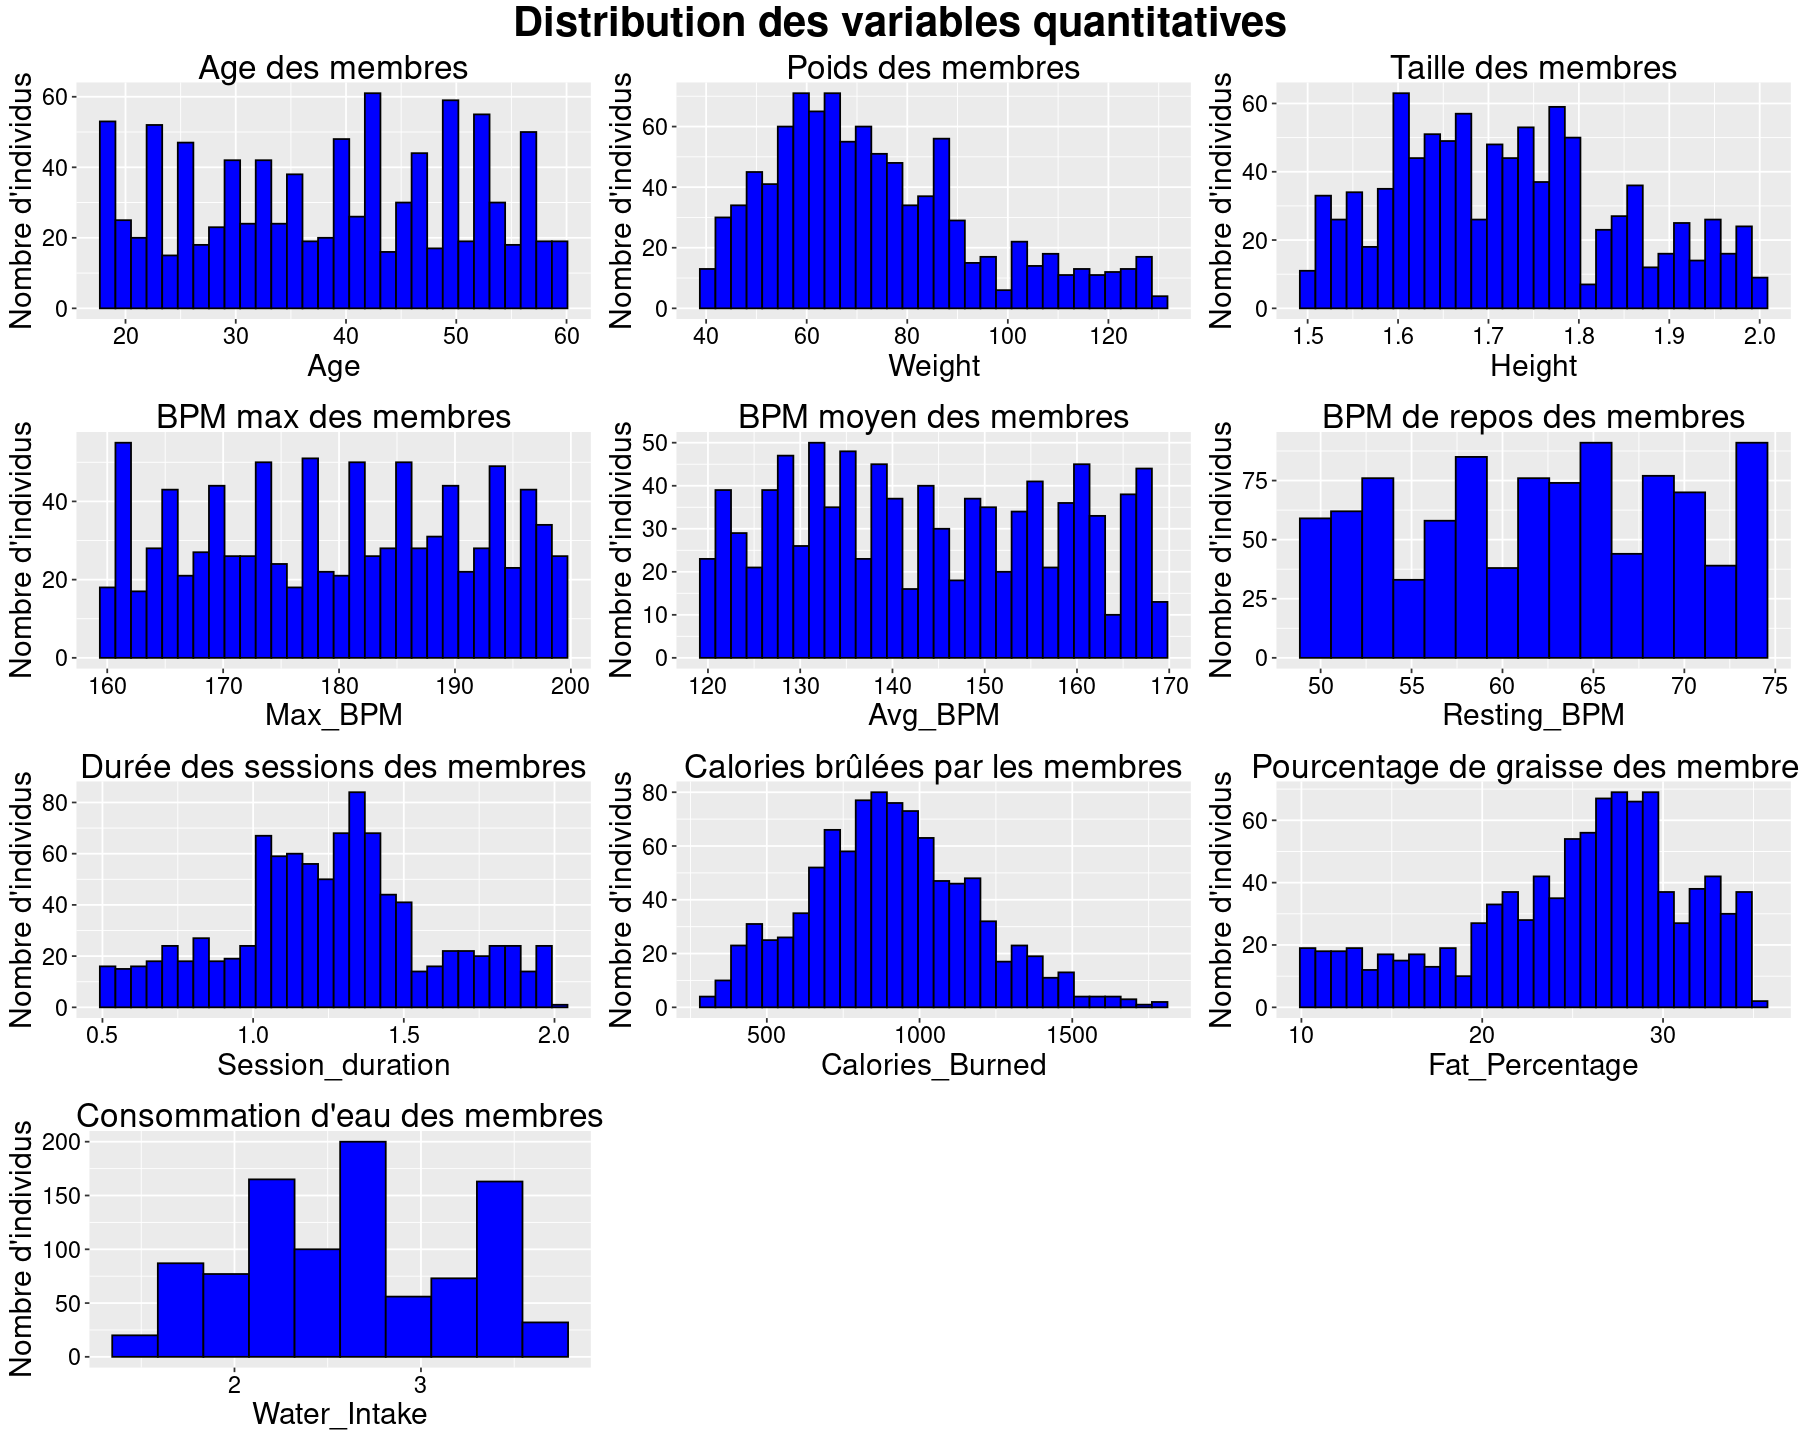

In [9]:
options(repr.plot.width=15, repr.plot.height=12)

g1 <- ggplot(gym, aes(Age)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Age des membres", x = "Age", y = "Nombre d'individus")

g2 <- ggplot(gym, aes(Weight..kg.)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Poids des membres", x = "Weight", y = "Nombre d'individus")

g3 <- ggplot(gym, aes(Height..m.)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Taille des membres", x = "Height", y = "Nombre d'individus")

g4 <- ggplot(gym, aes(Max_BPM)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "BPM max des membres", x = "Max_BPM", y = "Nombre d'individus")

g5 <- ggplot(gym, aes(Avg_BPM)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "BPM moyen des membres", x = "Avg_BPM", y = "Nombre d'individus")

g6 <- ggplot(gym, aes(Resting_BPM)) + 
    geom_histogram(bins = 15, fill = "blue", color = "black") + 
    labs(title = "BPM de repos des membres", x = "Resting_BPM", y = "Nombre d'individus")

g7 <- ggplot(gym, aes(Session_Duration..hours.)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Durée des sessions des membres", x = "Session_duration", y = "Nombre d'individus")

g8 <- ggplot(gym, aes(Calories_Burned)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Calories brûlées par les membres", x = "Calories_Burned", y = "Nombre d'individus")

g9 <- ggplot(gym, aes(Fat_Percentage)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Pourcentage de graisse des membres", x = "Fat_Percentage", y = "Nombre d'individus")

g10 <- ggplot(gym, aes(Water_Intake..liters.)) + 
    geom_histogram(bins = 10, fill = "blue", color = "black") + 
    labs(title = "Consommation d'eau des membres", x = "Water_Intake", y = "Nombre d'individus")

main <- "Distribution des variables quantitatives"
title1=text_grob(main, size = 25, face = "bold") 
grid.arrange(g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, ncol = 3, top = title1)
rm(g1, g2, g3, g4, g5, g6, g7, g8, g9, g10)

Les histogrammes montrent la distribution des différentes variables quantitatives dans le jeu de données.


En analysant les histogrammes, nous remarquons plusieurs points importants :  


- Certaines variables, comme **`Calories_Burned`, `Session_Duration`** et **`Water_Intake`**, suivent une distribution normale.  
- D'autres variables, comme **`Weight`** et **`Fat_Percentage`**, présentent une forte asymétrie et devront être transformées.  
- Toutes les variales restantes présentent une trop grosse variabilité des valeurs pour être transformées

**Conclusion** : Certaines variables présentent des écarts d'échelle importants, ce qui peut affecter nos analyses. Nous allons donc procéder à des transformations et normalisations dans la section suivante.  




In [10]:
gym[, "LWeight"] <- log(gym[,"Weight..kg."])
gym[, "SWeight"] <- sqrt(gym[,"Weight..kg."])

max_fat = max(gym[,"Fat_Percentage"])
gym[, "SFat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])
gym[, "LFat_Percentage"] <- log((max_fat + 1) - gym[,"Fat_Percentage"])

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


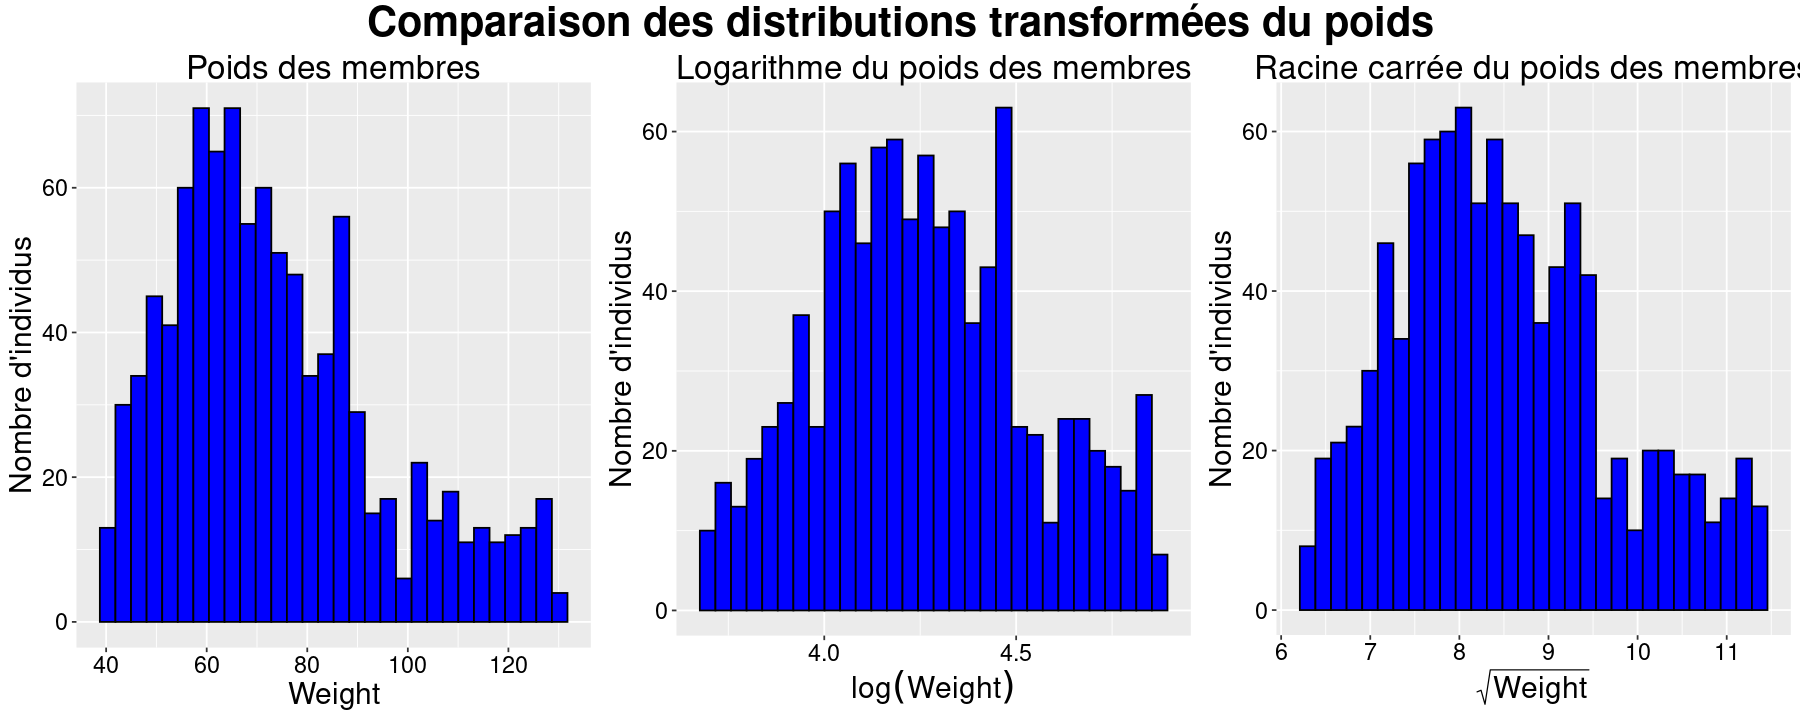

In [11]:
options(repr.plot.width=15, repr.plot.height=6)

g4 <- gg2 <- ggplot(gym, aes(Weight..kg.)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Poids des membres", x = "Weight", y = "Nombre d'individus")

g5 <- ggplot(gym, aes(LWeight)) +
    geom_histogram(fill = "blue", color = "black") +
    labs(title = "Logarithme du poids des membres", x = expression(log(Weight)), y = "Nombre d'individus")

g6 <- ggplot(gym, aes(SWeight)) +
    geom_histogram(fill = "blue", color = "black") +
    labs(title = "Racine carrée du poids des membres", x = expression(sqrt(Weight)), y = "Nombre d'individus")

main <- "Comparaison des distributions transformées du poids"
title1=text_grob(main, size = 25, face = "bold")
grid.arrange(g4, g5, g6, ncol = 3, top = title1)
rm(g4, g5, g6)


Suite à ces transformations, nous observons que la deuxième transformation, qui consiste à appliquer **le logarithme à la variable `Weight`**, est celle que nous allons retenir, car elle présente la distribution la plus proche de la normale.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


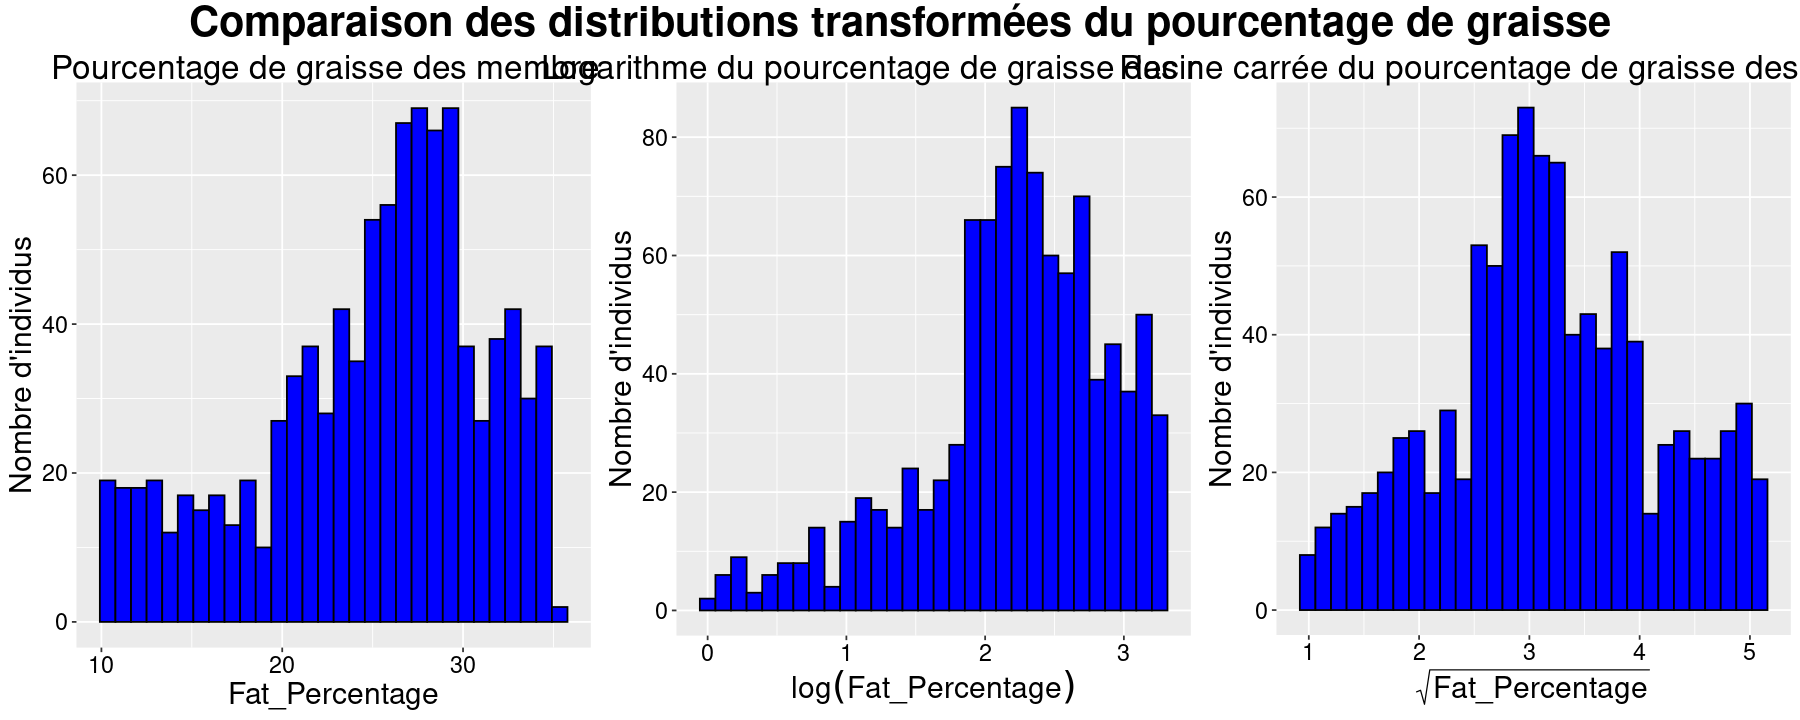

In [12]:
g1 <- ggplot(gym, aes(Fat_Percentage)) + 
    geom_histogram(fill = "blue", color = "black") + 
    labs(title = "Pourcentage de graisse des membres", x = "Fat_Percentage", y = "Nombre d'individus")

g2 <- ggplot(gym, aes(LFat_Percentage)) +
    geom_histogram(fill = "blue", color = "black") +
    labs(title = "Logarithme du pourcentage de graisse des membres", x = expression(log(Fat_Percentage)), y = "Nombre d'individus")

g3 <- ggplot(gym, aes(SFat_Percentage)) +
    geom_histogram(fill = "blue", color = "black") +
    labs(title = "Racine carrée du pourcentage de graisse des membres", x = expression(sqrt(Fat_Percentage)), y = "Nombre d'individus")

main <- "Comparaison des distributions transformées du pourcentage de graisse"
title1=text_grob(main, size = 25, face = "bold")
grid.arrange(g1, g2, g3, ncol = 3, top = title1)
rm(g1, g2, g3)

Suite à ces transformations, nous observons que la troisième transformation, qui consiste à appliquer **la racine carrée de `Fat_Percentage`**, est celle que nous allons retenir, car elle présente la distribution la plus proche de la normale.

In [13]:
gym_analyse <- gym[,c(1:14)]
gym[, "Weight..kg."] <- log(gym[,"Weight..kg."])

gym[, "Fat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])

# renome les variables Weight..kg. et BMI en LWeight et LBMI
names(gym)[names(gym) == "Weight..kg."] <- "LWeight"
names(gym)[names(gym) == "Fat_Percentage"] <- "SFat_Percentage"

# supprimer les colonnes 15 à 20
gym <- gym[, c(1:14)]

In [14]:
summary(gym)

      Age           Gender       LWeight        Height..m.       Max_BPM     
 Min.   :18.00   Female:462   Min.   :3.689   Min.   :1.500   Min.   :160.0  
 1st Qu.:28.00   Male  :511   1st Qu.:4.062   1st Qu.:1.620   1st Qu.:170.0  
 Median :40.00                Median :4.248   Median :1.710   Median :180.0  
 Mean   :38.68                Mean   :4.263   Mean   :1.723   Mean   :179.9  
 3rd Qu.:49.00                3rd Qu.:4.454   3rd Qu.:1.800   3rd Qu.:190.0  
 Max.   :59.00                Max.   :4.867   Max.   :2.000   Max.   :199.0  
    Avg_BPM       Resting_BPM    Session_Duration..hours. Calories_Burned 
 Min.   :120.0   Min.   :50.00   Min.   :0.500            Min.   : 303.0  
 1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040            1st Qu.: 720.0  
 Median :143.0   Median :62.00   Median :1.260            Median : 893.0  
 Mean   :143.8   Mean   :62.22   Mean   :1.256            Mean   : 905.4  
 3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460            3rd Qu.:1076.0  
 Max

### Analyse des variables qualitatives

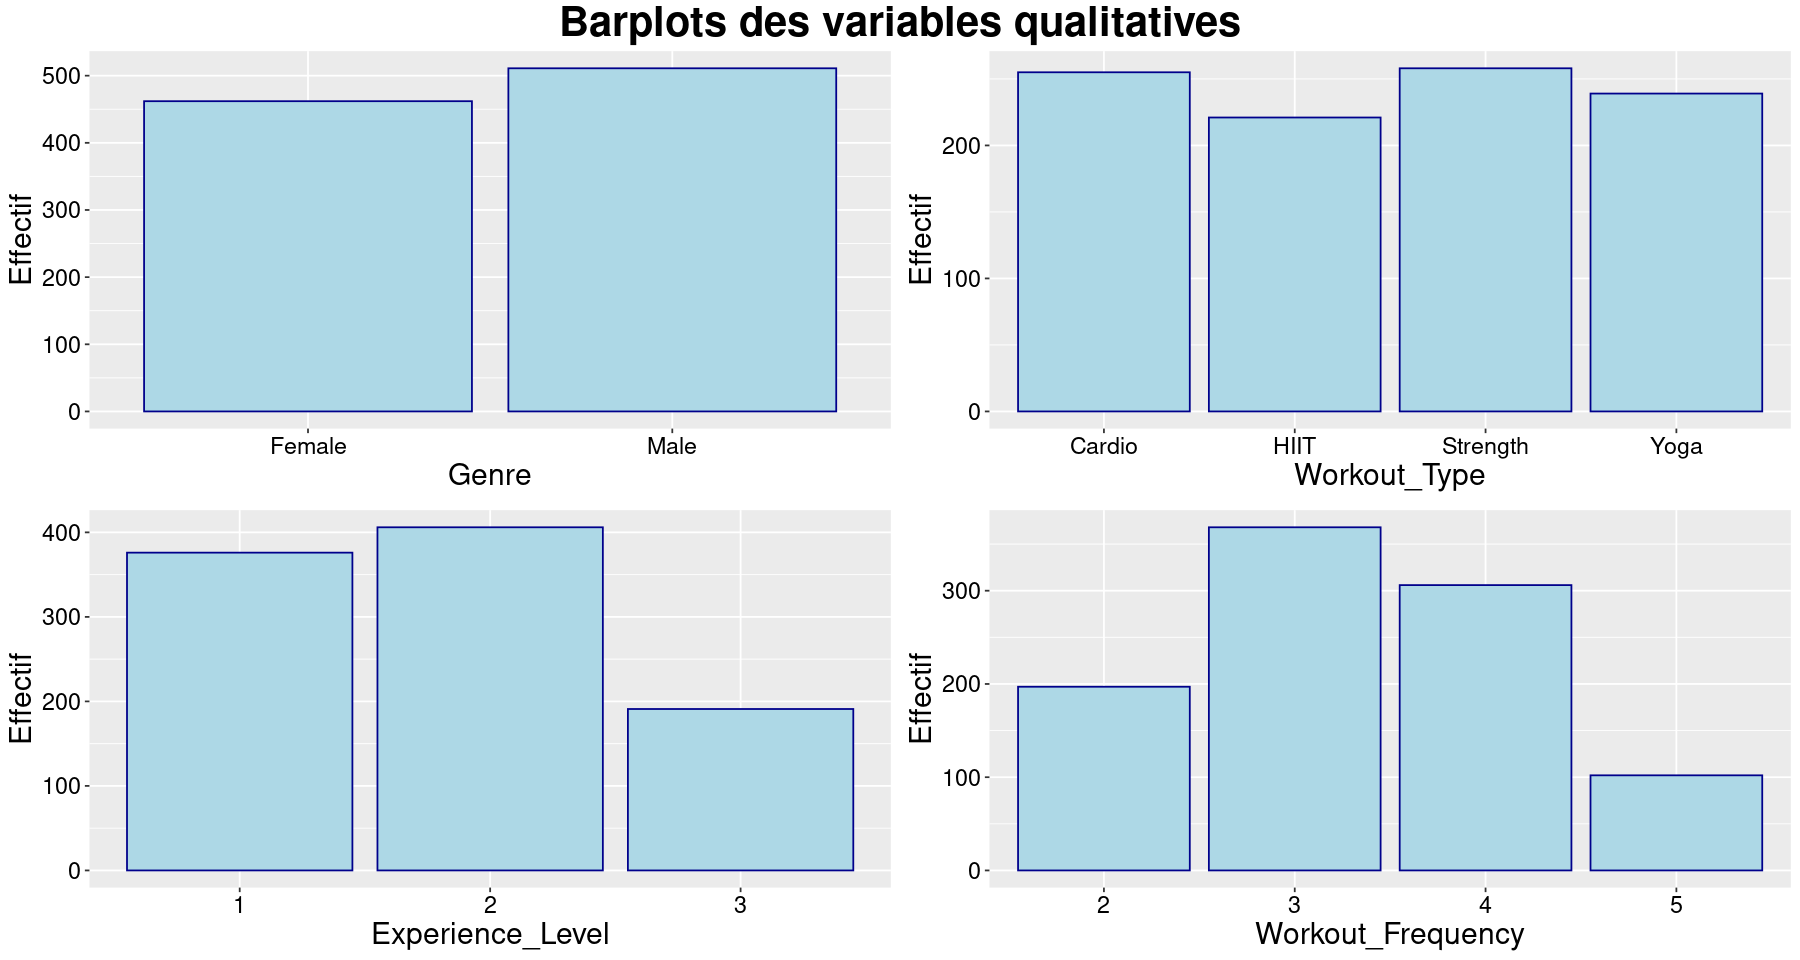

In [15]:
options(repr.plot.width=15, repr.plot.height=8)

# barplots pour les variables qualitatives
q1 <- ggplot(gym, aes(x = Gender)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(x = "Genre", y = "Effectif")

q2 <- ggplot(gym, aes(x = Workout_Type)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(x = "Workout_Type", y = "Effectif")

q3 <- ggplot(gym, aes(x = Experience_Level)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(x = "Experience_Level", y = "Effectif")

q4 <- ggplot(gym, aes(x = Workout_Frequency..days.week.)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(x = "Workout_Frequency", y = "Effectif")

main = "Barplots des variables qualitatives"
title1=text_grob(main, size = 25, face = "bold")
grid.arrange(q1, q2, q3, q4, ncol = 2, top = title1)

rm(q1, q2, q3, q4)


Les barplots illustrent la répartition des variables qualitatives comme suit :
1. **Genre** : Il y a davantage d'hommes que de femmes dans la salle de sport.
2. **Workout_Type** :  Les types d'entraînement sont divers, mais assez homogènes dans leur répartition
3. **Experience_Level** : La majorité des membres sont classés comme débutants ou intermédiaires.
4. **Workout_Frequency**: La fréquence varie, mais on observe une concentration autour de 3 à 5 jours d'entraînement par semaine.


Les mosaic plots montrent les relations entre les variables qualitatives :


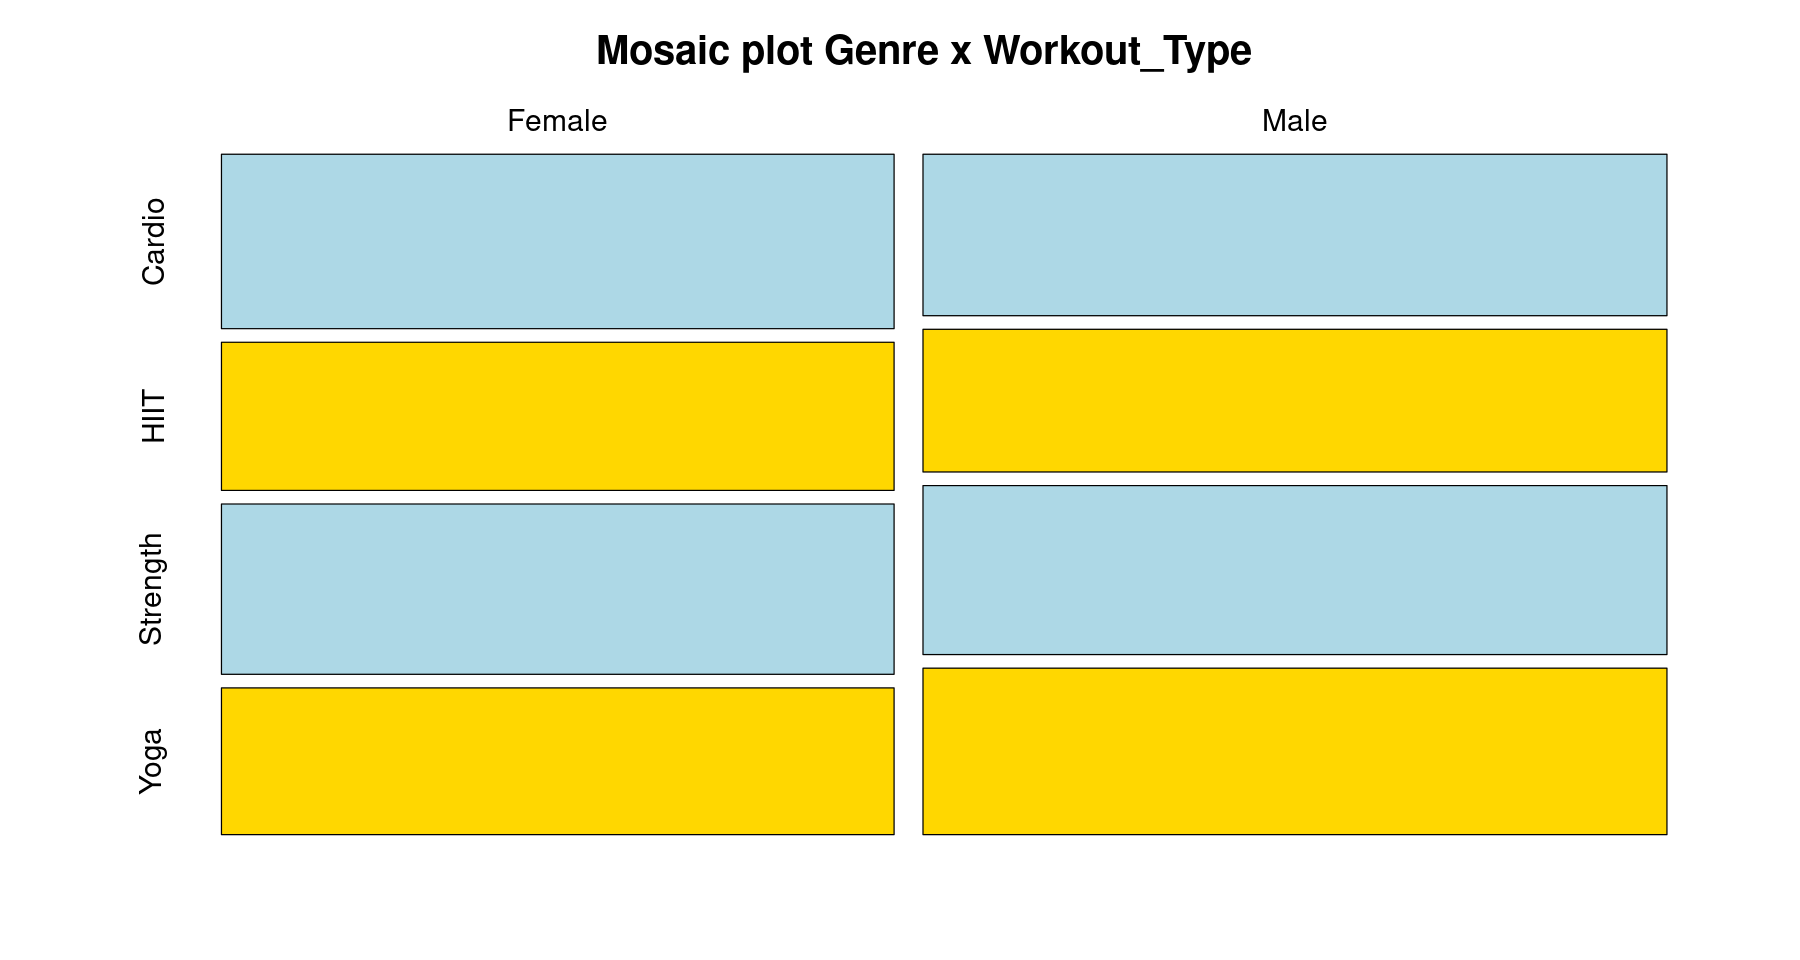

In [16]:
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 2,  # Main title
  cex.sub = 1.5    # Subtitle
)

# Générer des mosaic plot pour les variables qualitatives
mosaicplot(table(gym$Gender, gym$Workout_Type),
    main = "Mosaic plot Genre x Workout_Type", 
    color = c("lightblue", "gold"), cex.axis = 1.5)


`Genre` x `Workout_Type` : les hommes et les femmes ont des préférences similaires pour les types d'entraînement HIIT et Strength mais il y a plus de pratiquant de Yoga chez les hommes que chez les femmes, et plus de pratiquant de Cardio chez les femmes que chez les hommes.


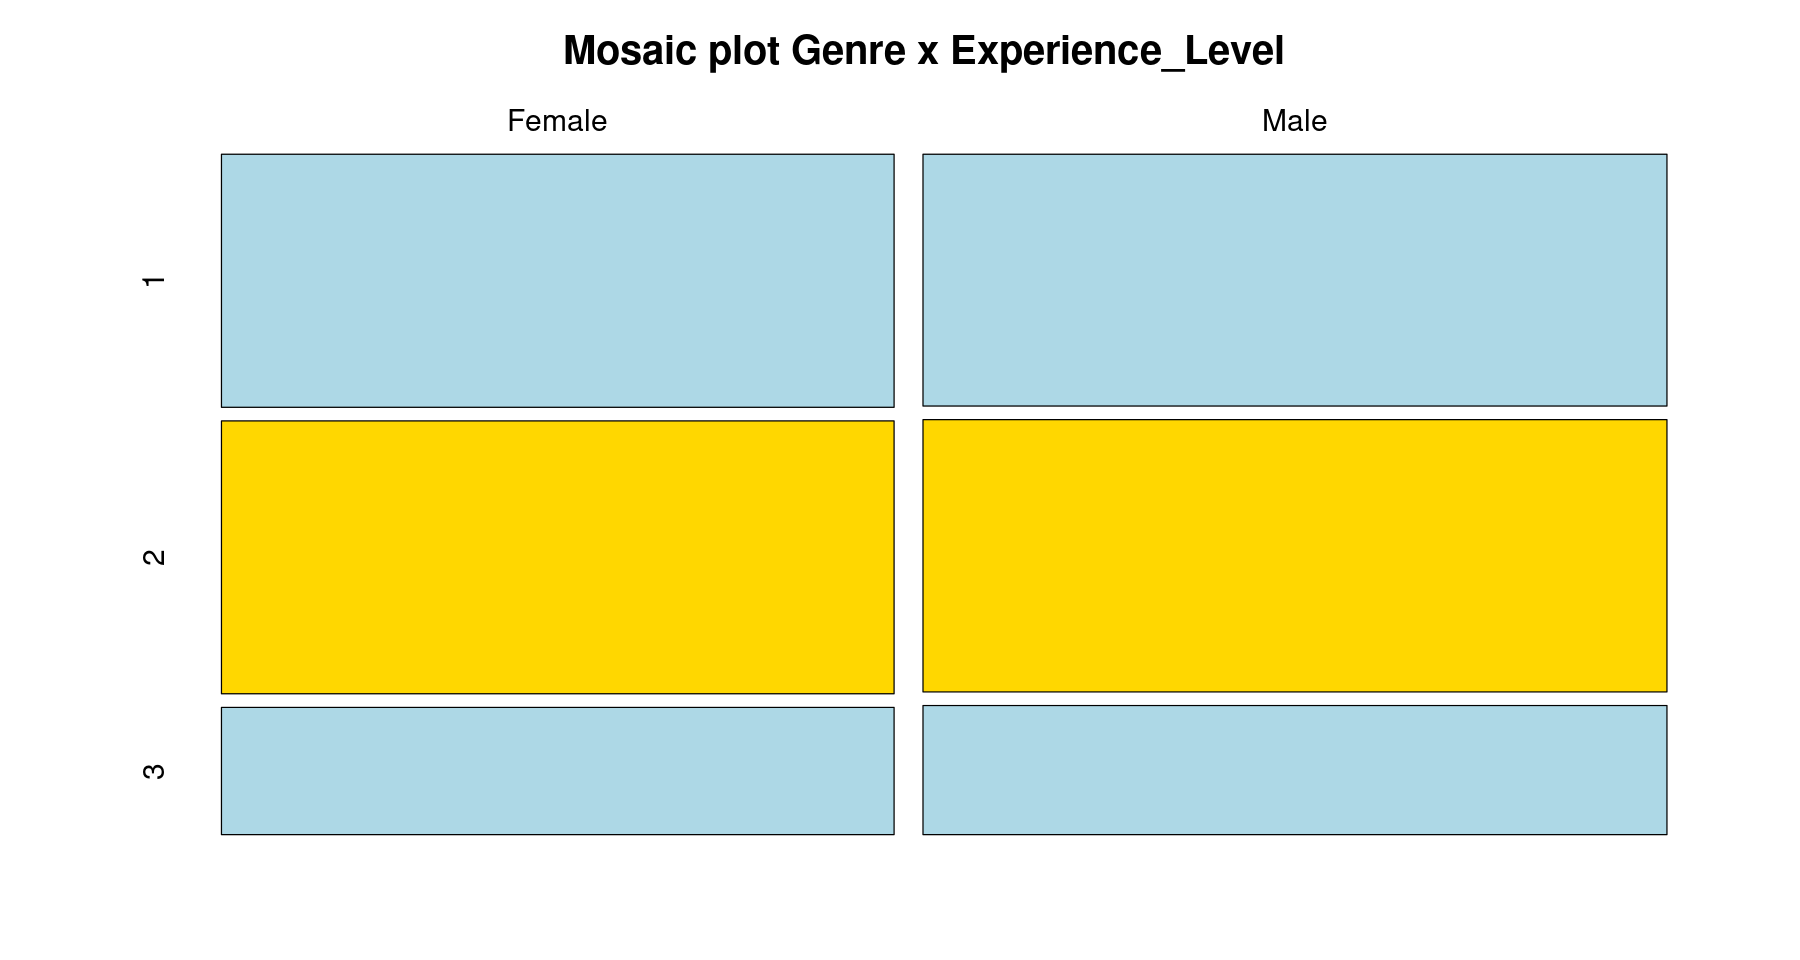

In [17]:
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 2,  # Main title
  cex.sub = 1.5    # Subtitle
)
mosaicplot(table(gym$Gender, gym$Experience_Level),
    main = "Mosaic plot Genre x Experience_Level",
    color = c("lightblue", "gold") , cex.axis = 1.5)

`Genre` x `Experienc_Level` : Les hommes et les femmes ont des niveaux d'expérience similaires.


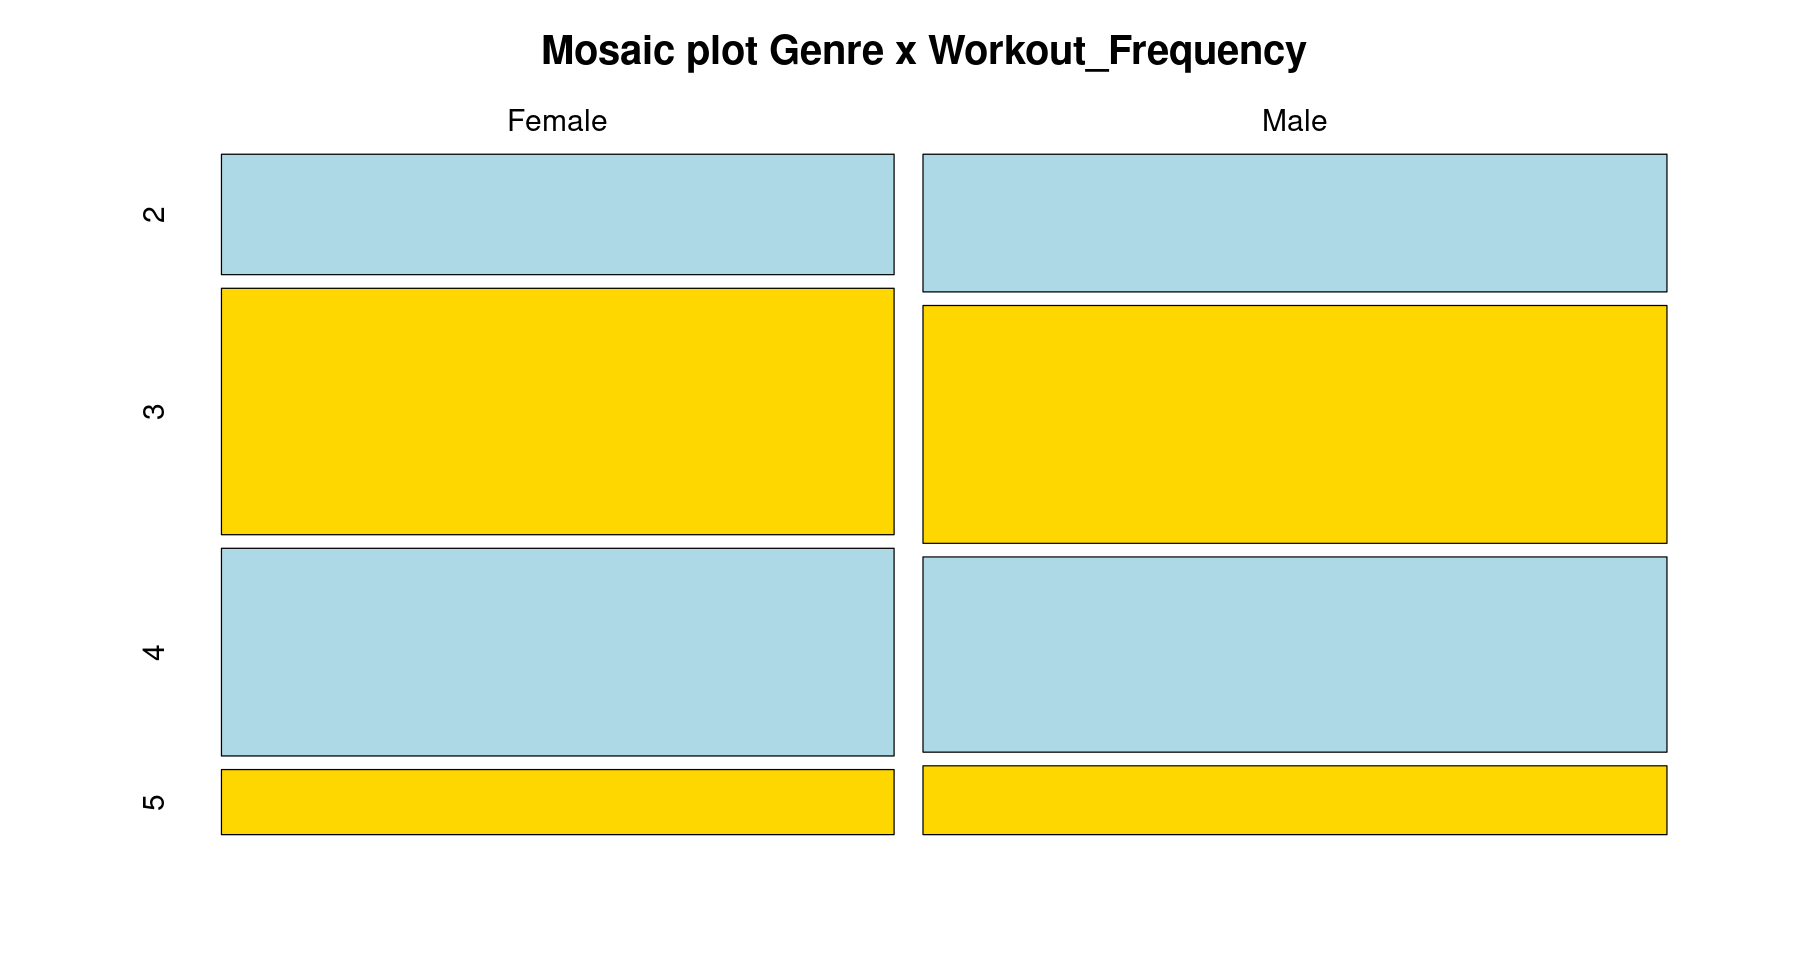

In [18]:
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 2,  # Main title
  cex.sub = 1.5    # Subtitle
)
mosaicplot(table(gym$Gender, gym$Workout_Frequency..days.week.),
    main = "Mosaic plot Genre x Workout_Frequency",
    color = c("lightblue", "gold"), cex.axis = 1.5)

`Genre` x `Workout_Frequency` : Il y un peu plus d'hommes qui s'entrainent 2x par semaine que les femmes, tandis qu'il y a plus de femmes qui s'entrainent 3 et 4 fois par semaine que les hommes. Pour 5 fois par semaine, il y en a autant.


In [19]:
# selectionner les variables quantitatives
gym_quanti = gym_analyse %>% select (Age, Weight..kg., Height..m., Max_BPM, Avg_BPM, Resting_BPM, Session_Duration..hours., Calories_Burned, Fat_Percentage, Water_Intake..liters.)

### Diagramme des corrélations

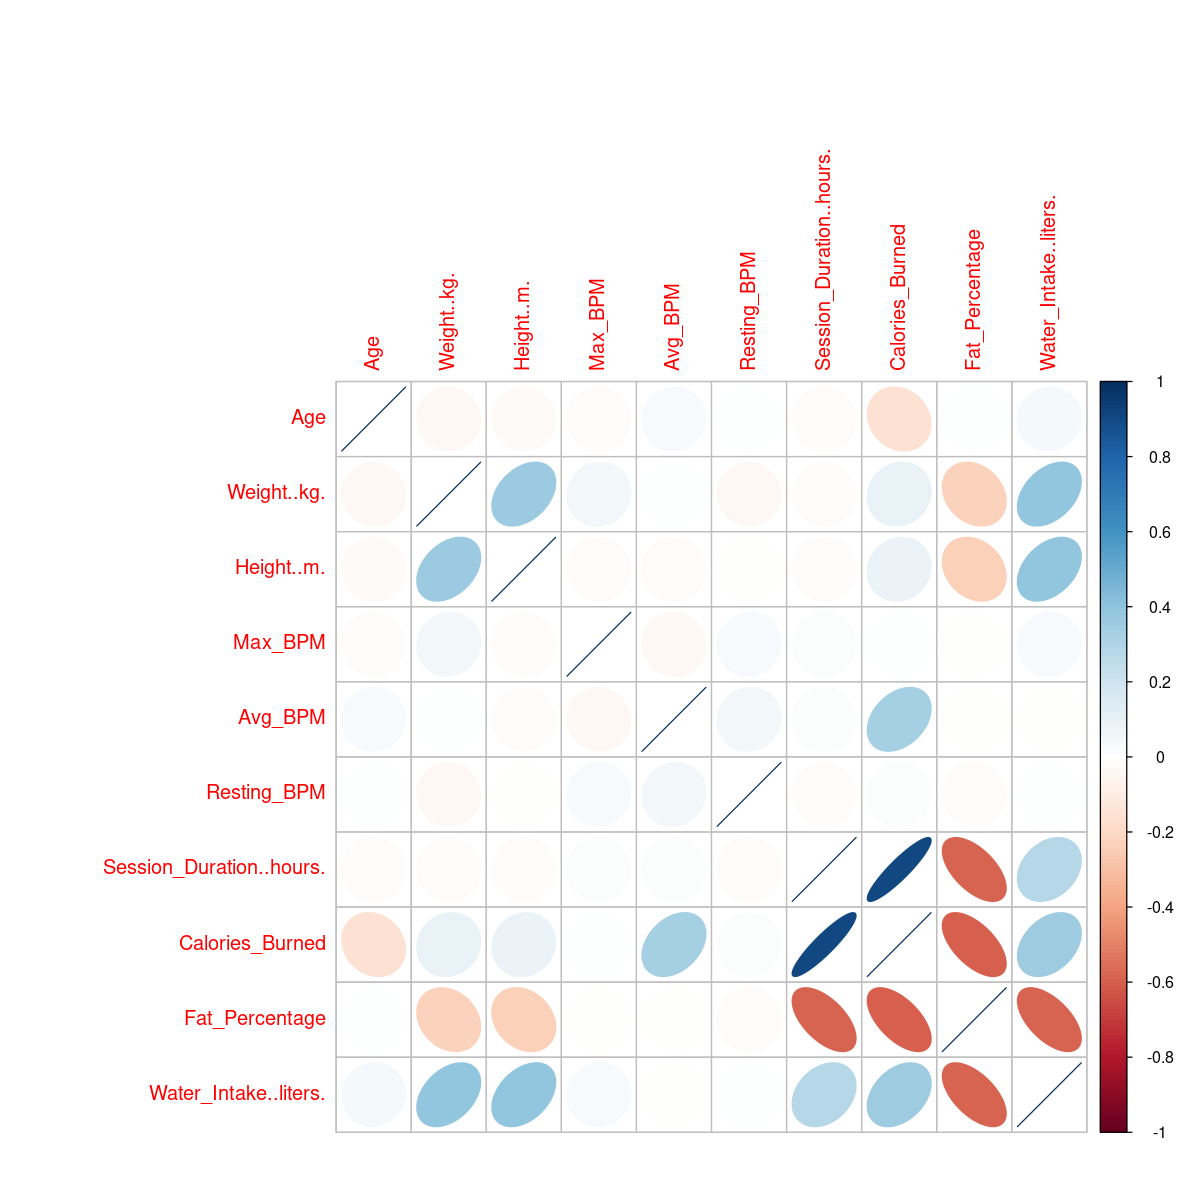

In [20]:
# matrice de corrélation
options(repr.plot.width=10, repr.plot.height=10)
corrplot(cor(gym_quanti), method = "ellipse")

Le corrplot ci-dessous montre les corrélations entre les variables quantitatives du jeu de données. Voici quelques observations clés :

- Une forte corrélation positive existe entre la durée de l'exercice (`Session_Duration`) et les calories brûlées (`Calories_Burned`), avec un coefficient de corrélation $r=0.91$. Cela correspond à l'attente selon laquelle **une durée d'exercice plus longue conduit généralement à une augmentation des calories brûlées**.
- Une moyenne correlation négative entre `Calories_Burned` et `Fat_Percentage` ($r = -0.60$) et `Session_Duration` et `Fat_Percentage` ($r = -0.58$) : Cela suggèrerait que **les individus avec un pourcentage de graisse plus élevé ne brûlent pas nécessairement plus de calories que la normale, et s'entraîraient moins longuement**, ce qui rejoindrait le point précedent sur les calories brulées et la durée de la séance.
- Une moyenne correlation entre `Fat_Percentage` et `Water_Intake` ($r = -0.59$). Cette relation pourrait indiquer que **les individus avec un meilleur niveau d'hydratation ont potentiellement une masse grasse corporelle moins élevée**.


Ces corrélations peuvent aider à identifier les relations entre les variables et à guider les analyses ultérieures, telles que la sélection de variables pour les modèles prédictifs.

### Reduction de dimension par ACP

Nous avons inclus `Calories_Burned` en tant que variable quantitative supplémentaire (`quanti.sup`) pour analyser sa corrélation avec les composantes principales, sans influencer leur construction. La variable `Experience_Level` a été placée en qualitative supplémentaire (`quali.sup`) afin de visualiser les groupes d’individus par niveau d’expérience. Cette approche permet de séparer clairement les variables explicatives (actives) des variables à prédire (supplémentaires), conformément à l’objectif de prédiction.

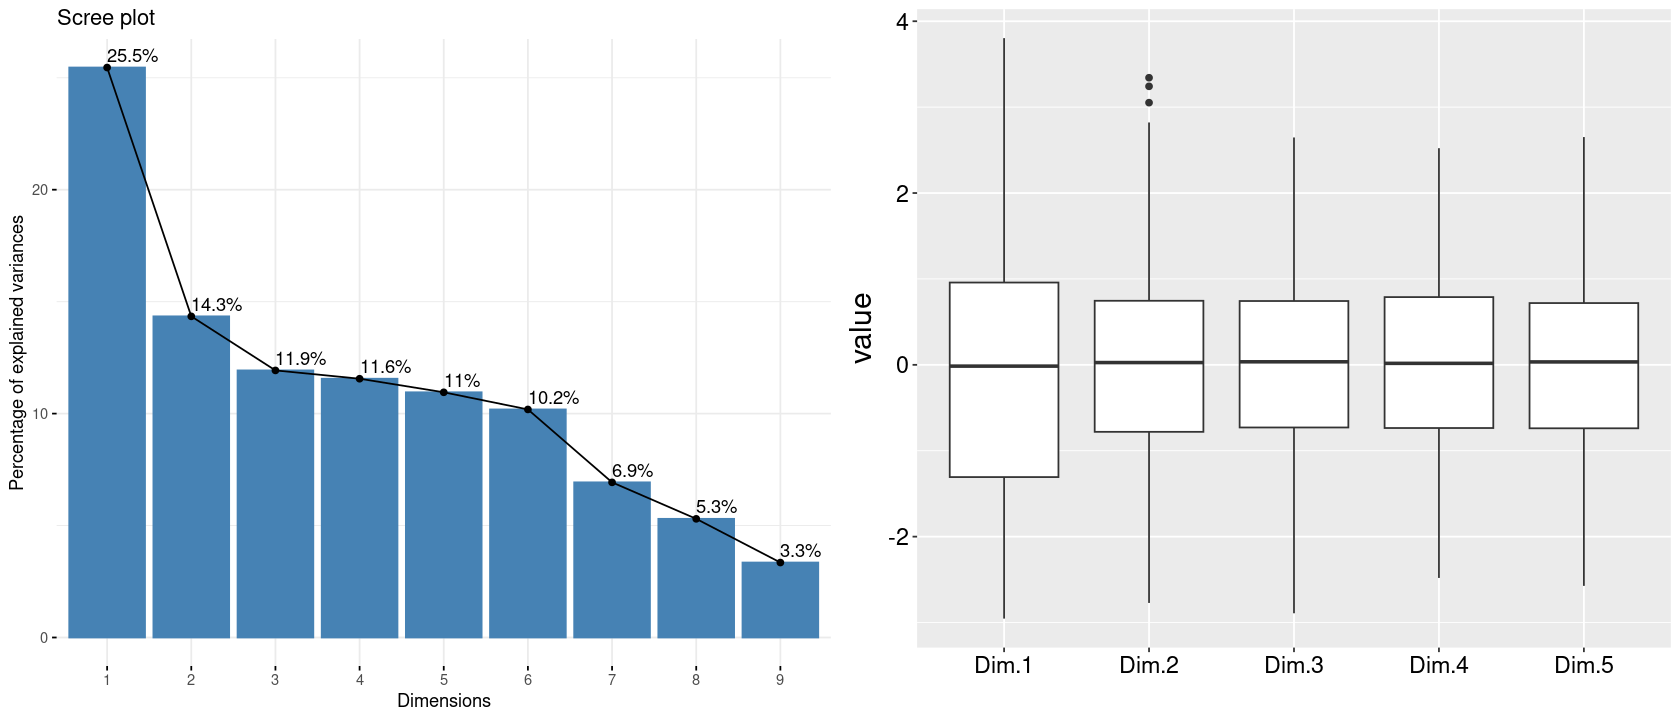

In [21]:
# Analyse en composantes principales
acp <- PCA(gym_analyse, scale.unit = TRUE, graph = FALSE, quali.sup = c(2, 10, 13, 14) , quanti.sup = c(9), ncp = 5)
# summary(acp)

options(repr.plot.width=14, repr.plot.height=6)

# Décroissance des valeurs propres
library(factoextra)
g1<-fviz_eig(acp, addlabels = TRUE)
library(reshape2)
g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)


L’analyse des valeurs propres montre une structure multidimensionnelle des données. La méthode du coude, suggère de retenir **2 voire 3 composantes** (39% ou 51% d’inertie), mais celles-ci ne suffisent pas à résumer l’information. **Pour capturer 80% de la variance, 6 composantes sont nécessaires**, ce qui indique que les variables explicatives sont relativement indépendantes ou que plusieurs facteurs latents contribuent à la variabilité des données.

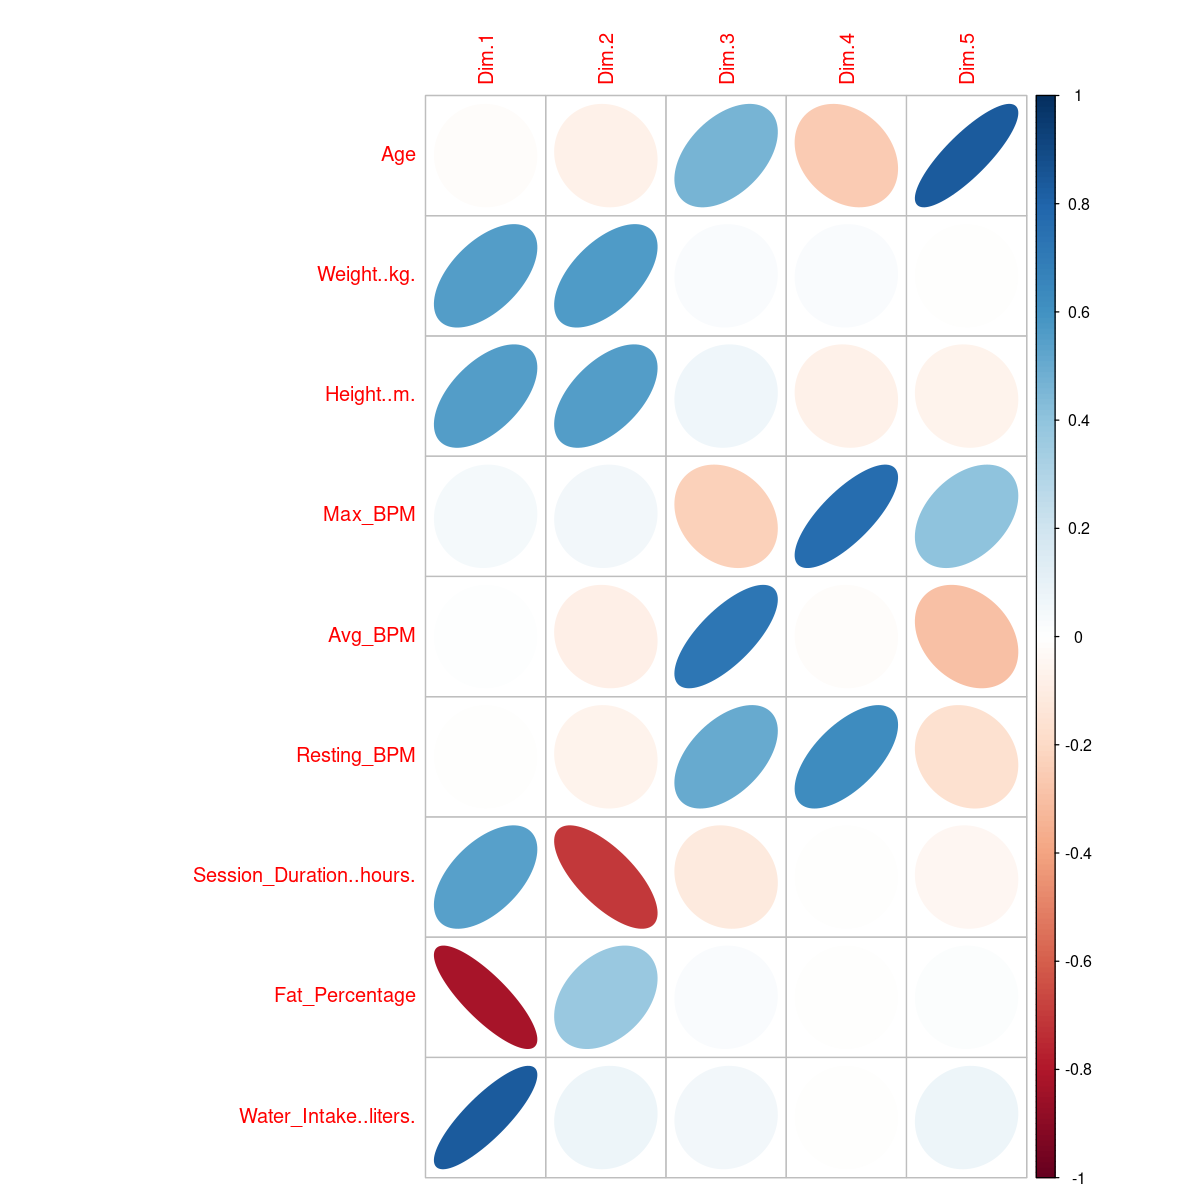

In [22]:
options(repr.plot.width=10, repr.plot.height=10)
corrplot(acp$var$cor, is.corr=TRUE,method="ellipse")

L'analyse du graphique des correlations des variables d'intérêt avec les dimensions réduites indique :

- les variables `LWeight`, `Height`, `Session_Duration..hours.`, `SFat_Percentage`, `Water_Intake..liters` contribuent fortement à la première dimension.
- pour la deuxième dimension, on retrouve `LWeight`, `Height` et `Session_Duration..hours.`, mais cette fois-ci, `Session_Duration..hours.` est opposé au deux autres.
- les variables `Age`, `Max_BPM`, `Avg_BPM` et `Resting_BPM` contribuent à la troisième dimension. 

Analysons désormais leur effets sur les graphes des variables ci-dessous.

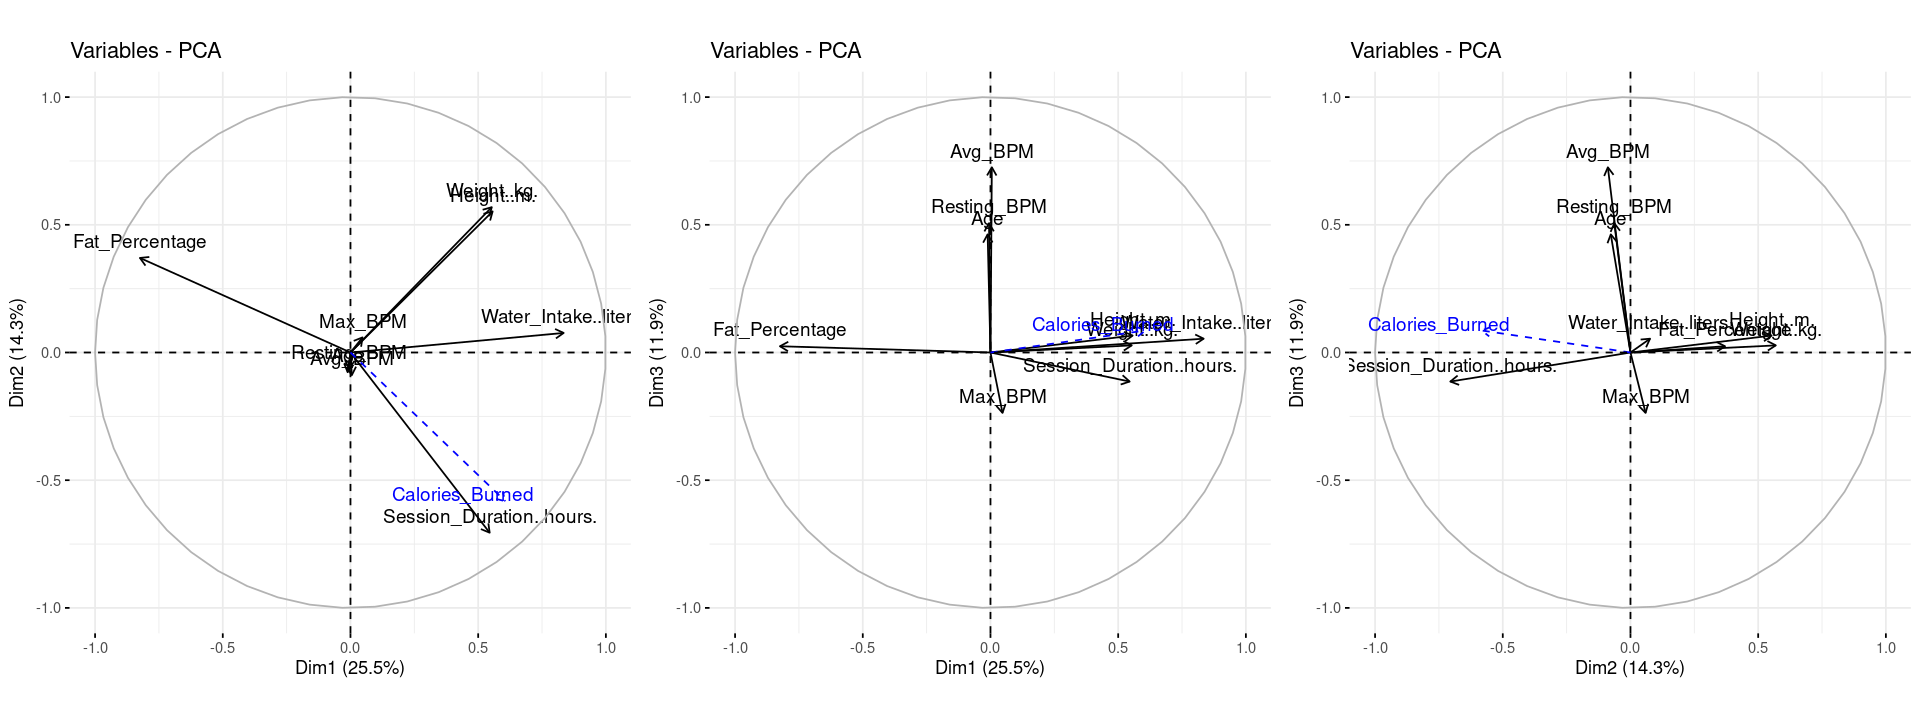

In [23]:
options(repr.plot.width=16, repr.plot.height=6)

par(original_par)
g1 <- fviz_pca_var(acp,axes=c(1,2))
g2 <- fviz_pca_var(acp,axes=c(1,3))
g3 <- fviz_pca_var(acp,axes=c(2,3))

grid.arrange(g1, g2, g3, ncol = 3)
rm(g1, g2, g3)

Les trois graphiques ci-dessus représentent la projection des features et de notre variable d'intêret `Calories_Burned` selon les dimensions (1, 2 ou 3).

- Sur les graphiques 1 et 3, on remarque que notre variable d'intêret `Calories_Burned` est fortement corrélée linéairement à `Session_Duration..hours.`, ce qui suggère que **le nombre de calories dépénd fortement de la durée de l'entraînement**.
- Sur le 1er graphique, on remarque que `Weight` et `Height` sont très fortement corrélés linéairement, ce qui impliquerait que **plus un individu est grand, plus il est lourd**.
- Sur le 1er graphique, on remarque que, selon la 2e dimension,  `Fat_Percentage` et `Water_Intake..liters.` sont négativement corrélés linéairement, ce qui suggère que **les individus à faible masse grasse auront tendance à boire plus d'eau que les autres**. On retrouve cette corrélation linéaire sur le 2e graphique selon la 3e dimension cette fois-ci.
- Enfin, sur les graphiques 2 et 3, on remarque que les variables `Age`, `Max_BPM`, `Avg_BPM` et `Resting_BPM` sont linéairement corrélées, en soulignant que la variable `Max_BPM` est corrélée négativement par rapport aux autres. Dans une moindre mesure, cela pourrait impliquer que :
    - **la fréquence maximale lors d'un effort** d'un individu **diminue avec l'âge**.
    - **Les efforts requierent un BPM moyen plus elevé lorsque l'âge augmente**, à moins que les personnes plus agées préfèrent des efforts impliquant un BPM moyen plus élévé (course à pied, HIIT) mais cela sera vérifié avec la variable quantitative `Workout_Type`.
    - Enfin, il semblerait que **la fréquence cardiaque au repos augmente avec l'âge**.

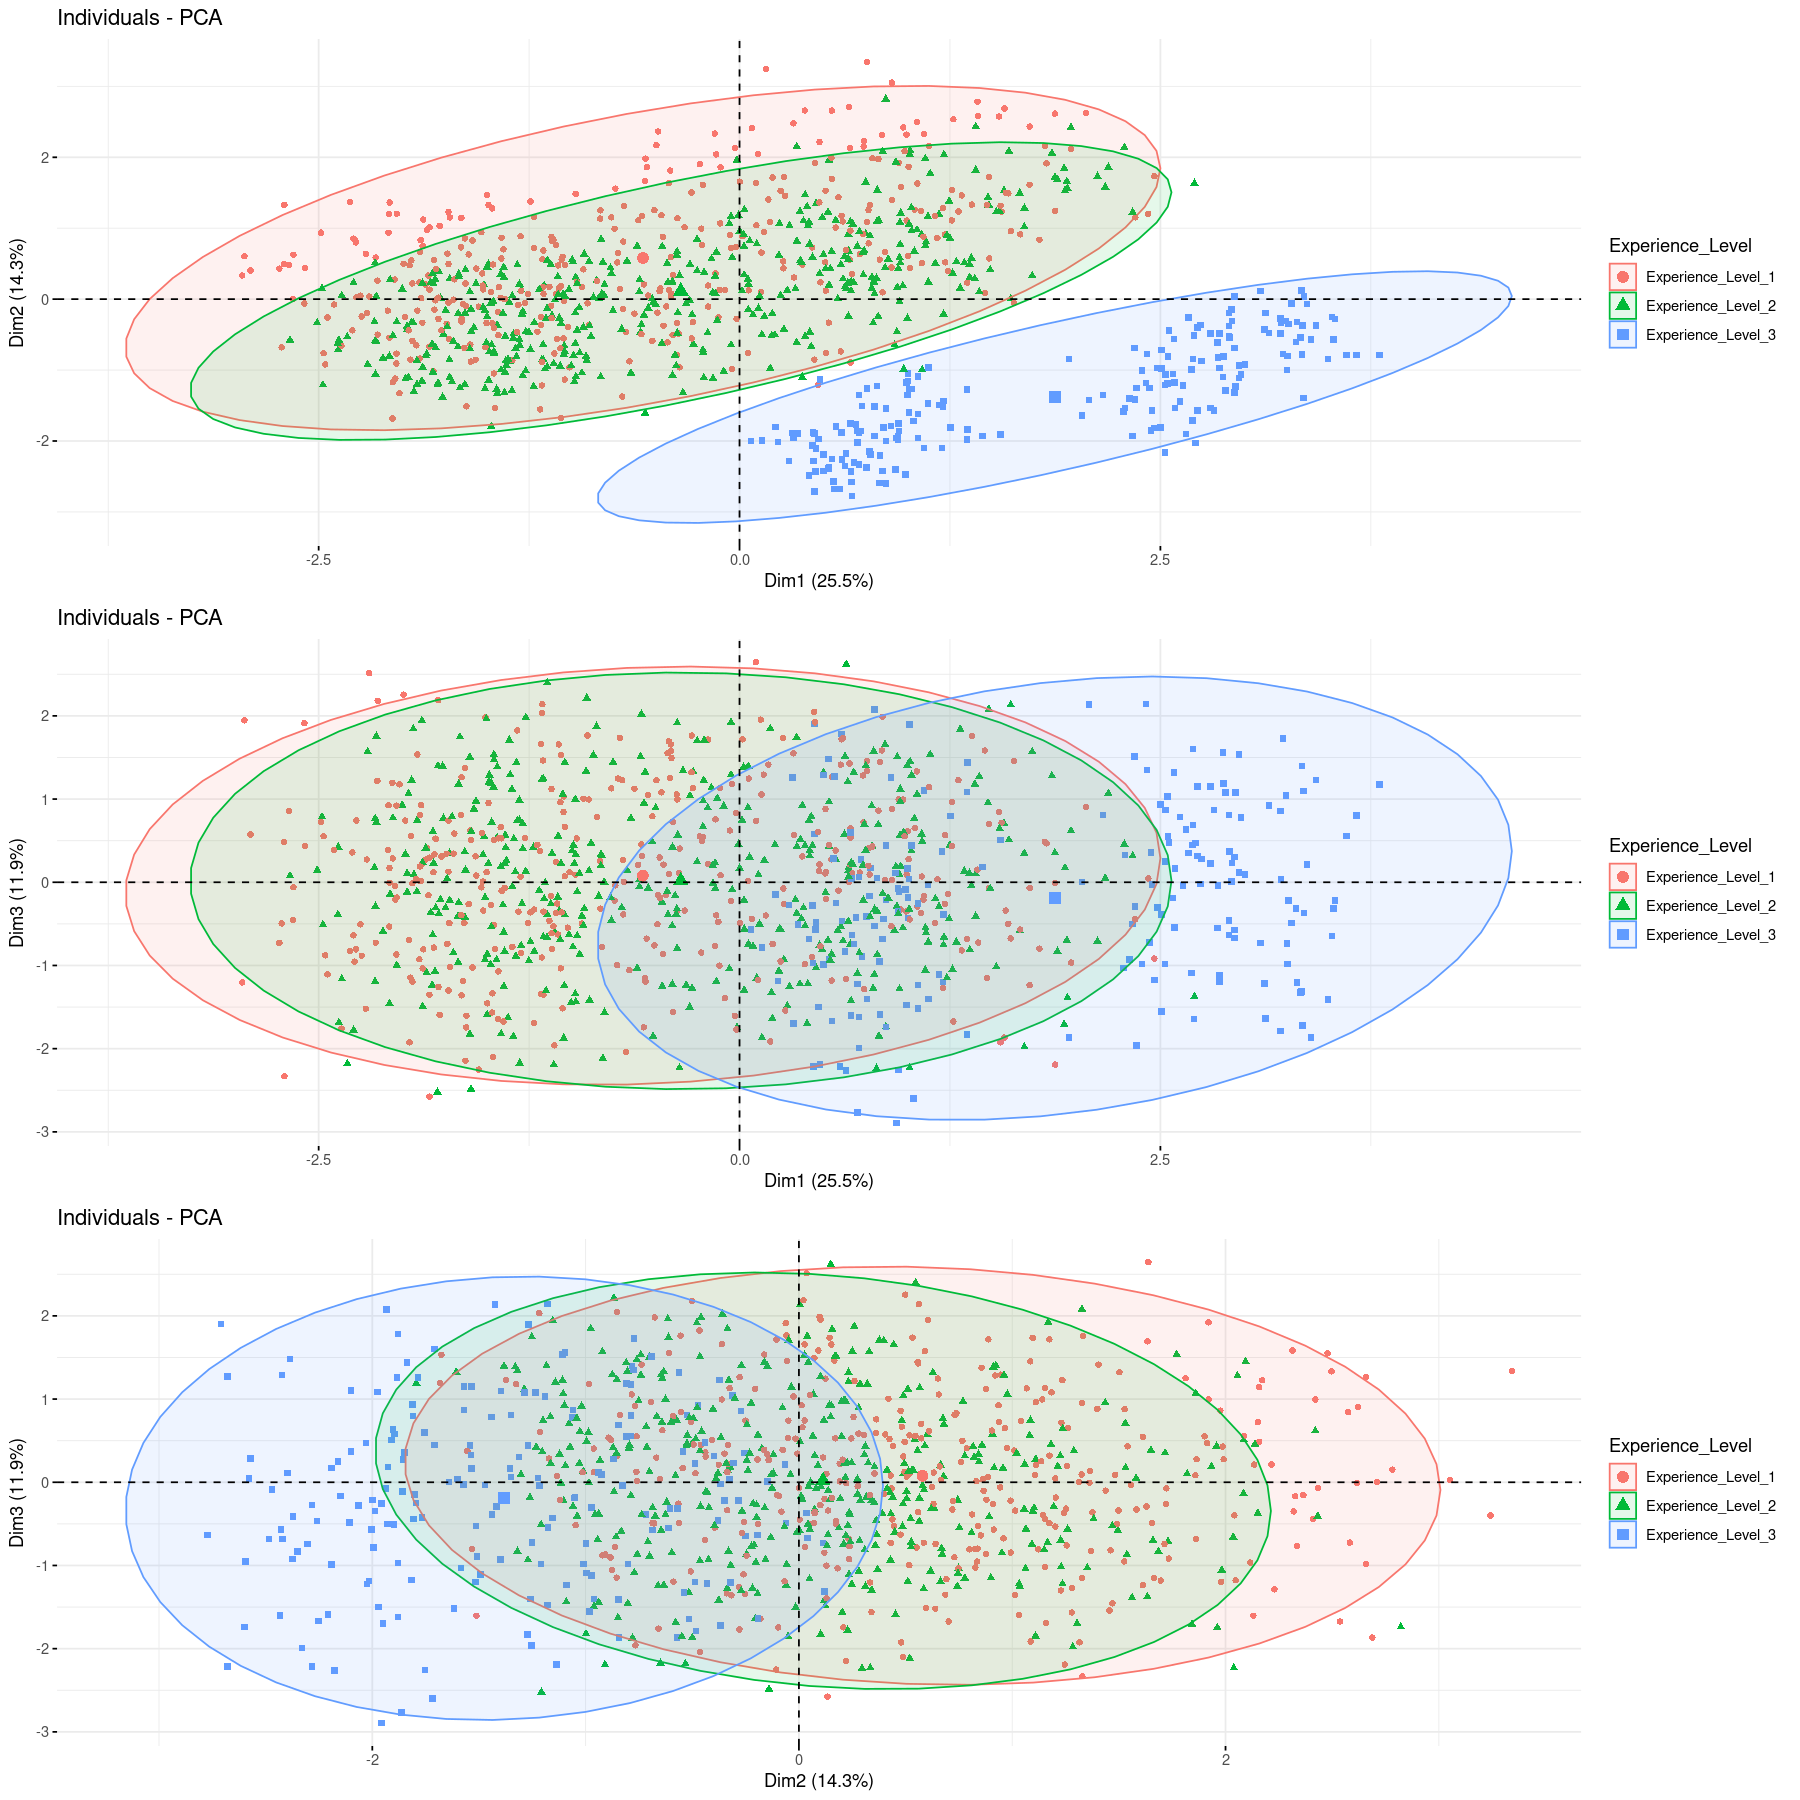

In [24]:
options(repr.plot.width=15, repr.plot.height=15)

g1 <- fviz_pca_ind(acp, label="none", habillage = 14,
    axes=c(1,2), addEllipses = TRUE)
g2 <- fviz_pca_ind(acp, label="none", habillage = 14,
    axes=c(1,3), addEllipses = TRUE)
g3 <- fviz_pca_ind(acp, label="none", habillage = 14,
    axes=c(2,3), addEllipses = TRUE)

grid.arrange(g1, g2, g3, ncol = 1)
rm(g1, g2, g3)

Les trois graphiques ci-dessus projète les individus dans les principaux plans facotriels. Chaque individu est colorié selon son niveau d'expérience (`Experience_Level`), qui est notre seconde variable à prédire.

La projection des individus selon leur niveau d’expérience révèle une séparation partielle dans l’espace des composantes principales. Les experts (niveau 3) se distinguent nettement des autres groupes dans le plan Dim.1-2, tandis que les débutants et intermédiaires partagent des profils similaires. Bien que les structures de covariance soient homogènes (ellipses parallèles), la discrimination complète des trois niveaux nécessitera probablement une combinaison de modèles linéaires (pour isoler les experts) et non linéaires (pour différencier les non-experts)

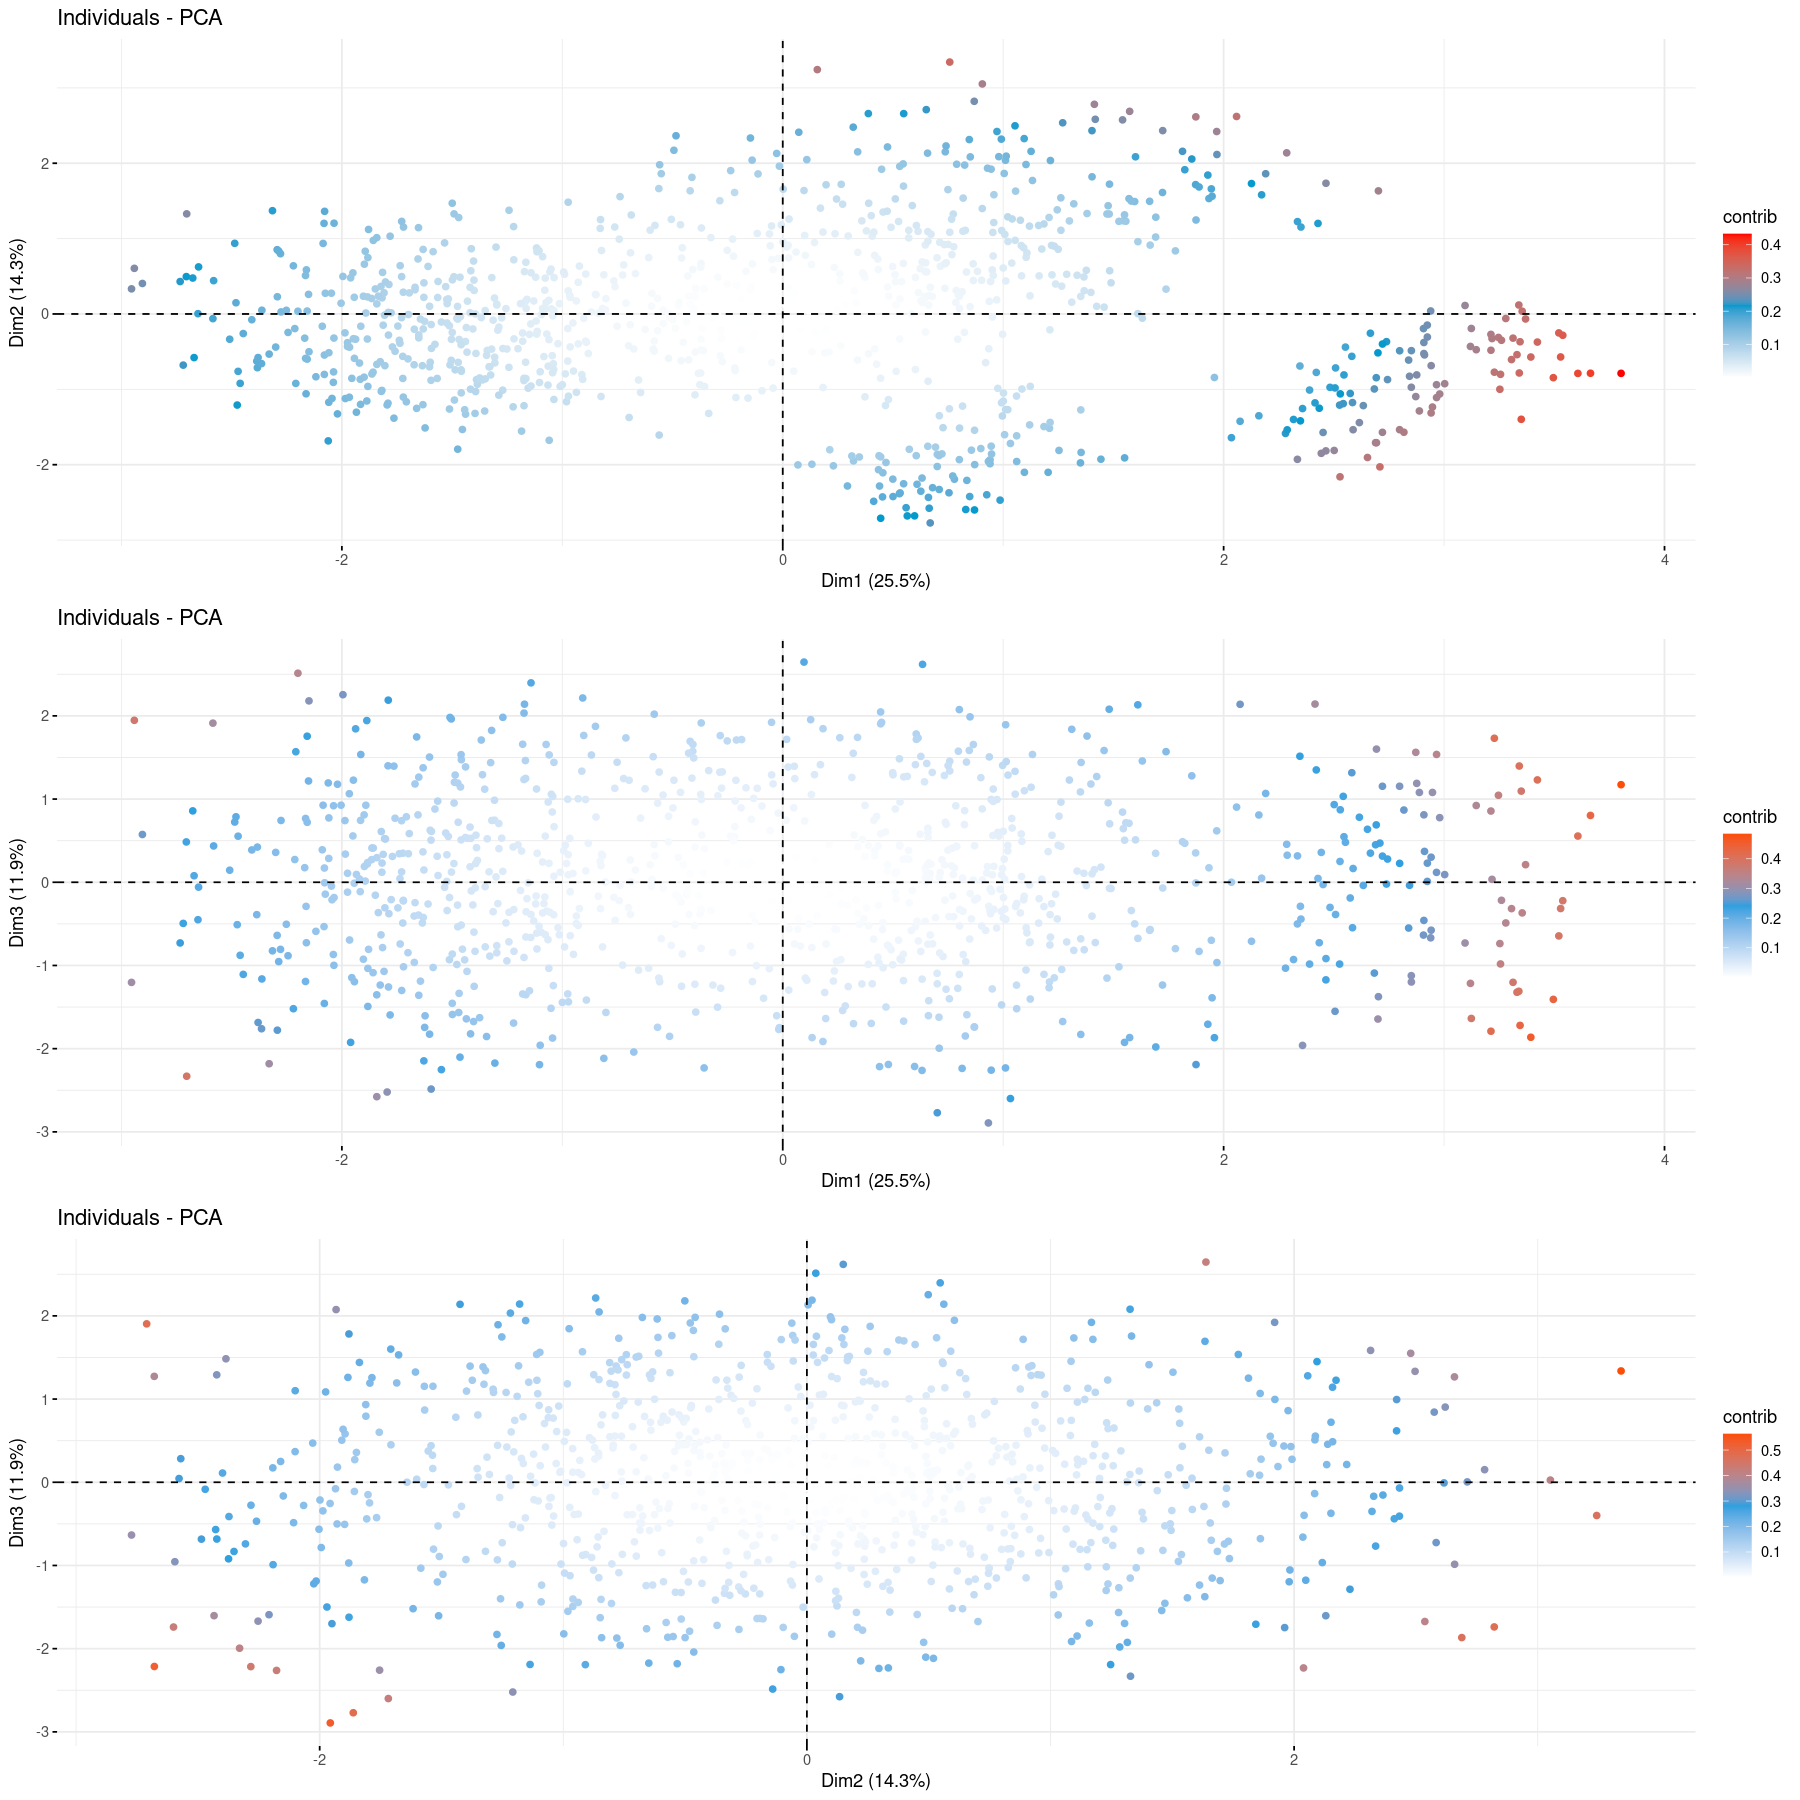

In [25]:
options(repr.plot.width=15, repr.plot.height=15)

g1 <- fviz_pca_ind(acp,col.ind="contrib",label="true",gradient.cols = c("white", "deepskyblue3", "red" ))
g2 <- fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))
g3 <- fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(2,3))

grid.arrange(g1, g2, g3, ncol = 1)
rm(g1, g2, g3)

Les trois graphiques ci-dessus projète les individus dans les principaux plans facotriels, mais cette fois-ci, les individus sont coloriés en fonction de leur contribution. La contribution d’un individu à une composante **mesure son influence** sur la variance expliquée par cette composante.

Les points en rouge correspondent aux individus ayant un poids disproportionné sur l’orientation des axes. Ils pourraient biaiser l'orientation des axes (ex: bodybuilders extrêmes, débutants complets).

On retrouve en bas à droite du 1er graphique un groupe d'outliers correspondant aux individus expérimentés (`Experience_Level` = 3). Certains possèdent une contribution très élevée sur la dimension 1 et il serait pertinent de vérifier leurs valeurs. Il correspondraient probablement à des individus ayant des **morphotypes extrêmes** (très grands/lourds, ou au contraire très petits/léger), **excessivement sec** (masse grasse très faible) ou inversement. Il pourraient aussi correspondre à des personnes **buvant énormément ou peu d'eau**. On retrouve un résultat similaire sur le graphique n°2, selon la dimension 1, qui correspond sûrement au même groupe de personnes.

On détecte aussi les individus influents sur **l’interaction entre durée de séance (Dim.2) et paramètres cardiaques (Dim.3)**. Ils pourraient représenter des individus à **séances très longues** et/ou à **fréquences cardiaques extrêmes**.

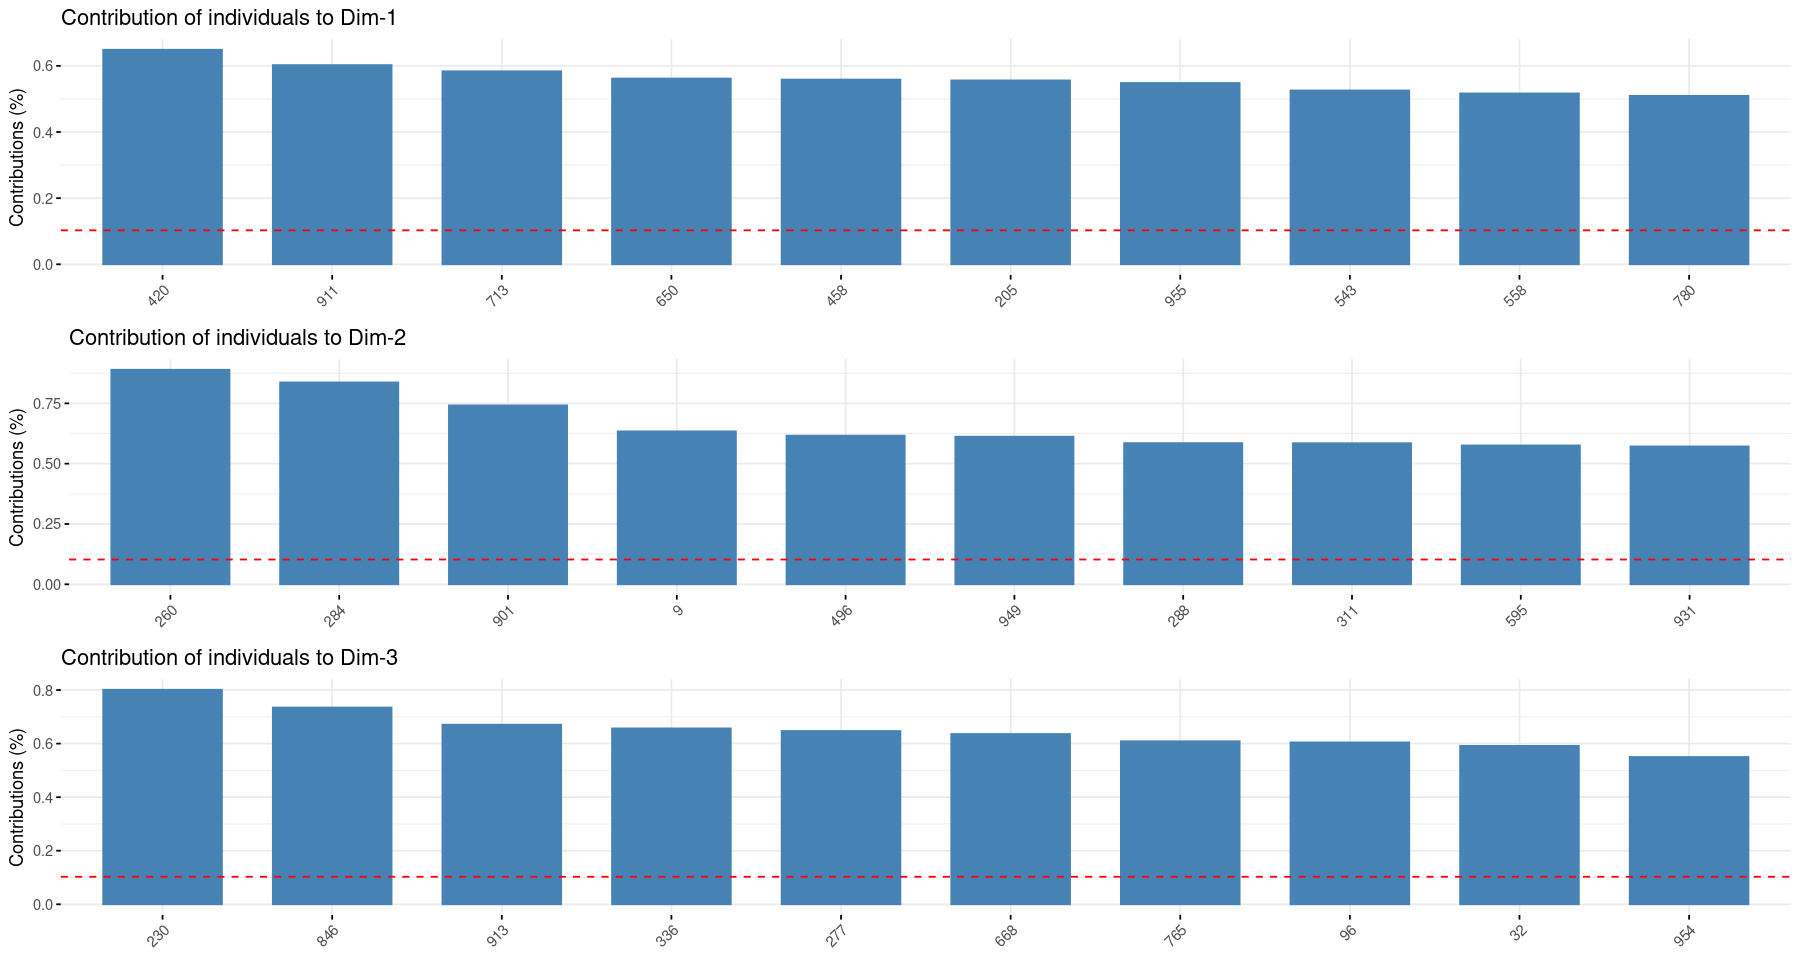

In [26]:
options(repr.plot.width=15, repr.plot.height=8)
# analyse des outliers
g1 <- fviz_contrib(acp, choice = "ind", axes = 1, top = 10)
g2 <- fviz_contrib(acp, choice = "ind", axes = 2, top = 10)
g3 <- fviz_contrib(acp, choice = "ind", axes = 3, top = 10)

grid.arrange(g1, g2, g3, ncol = 1)
rm(g1, g2, g3)

In [27]:
# display the outliers : 420, 711, 713 and 650
gym_analyse_median <- apply(gym_analyse, 2, median)
print("Median values:")
gym_analyse_median
gym_analyse[c(420, 711, 713, 650),]

[1] "Median values:"


Age                        Gender 
                         "40"                        "Male" 
                  Weight..kg.                    Height..m. 
                      " 70.0"                        "1.71" 
                      Max_BPM                       Avg_BPM 
                        "180"                         "143" 
                  Resting_BPM      Session_Duration..hours. 
                         "62"                        "1.26" 
              Calories_Burned                  Workout_Type 
                       " 893"                    "Strength" 
               Fat_Percentage         Water_Intake..liters. 
                       "26.2"                         "2.6" 
Workout_Frequency..days.week.              Experience_Level 
                          "3"                           "2"

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
420,47,Male,86.6,1.99,182,153,70,1.98,1500,Strength,10.6,3.5,4,3
711,38,Male,123.3,1.62,161,165,65,1.34,1216,Yoga,21.2,2.3,4,2
713,19,Male,82.4,1.96,174,169,62,1.90,1766,HIIT,10.1,3.5,5,3
650,27,Male,88.5,1.98,161,153,53,1.80,1515,Cardio,11.1,3.5,4,3


Selon la dim. 1, analysons les 4 individus ayant une forte contribution en les comparant à la médiane du dataset, en regardant particulièrement `Weight`, `Height`, `Session_Duration..hours.`, `Fat_Percentage` et `Water_Intake`.

Les individus 420, 713 et 650 sont des individus **très grands**, (~1m97 par rapport à la médiane = 1.71), **qui s'entrainent longuement** (~1.90 hours par rapport à 1.26 hours), qui ont **une masse grasse bien en-dessous de la médiane** (~10.5% par rapport à 26.2%) et **qui boivent beaucoup d'eau** (3.5 litres par rapport à 2.6 litres). Ils correspondent très exactement aux valeurs extrêmes dans les variables contribuant énormément pour la dimension 1.

L'individu 711 en revanche est **très lourd et très petit**, et avec d'autres métriques dans la moyenne. Il correspond réellement à une valeur complètement abbérante.

In [28]:
# display the outliers for dim 2
gym_analyse[c(260, 284, 901, 9),]

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
260,53,Male,125.1,1.91,171,137,70,0.52,353,Strength,28.3,3.1,2,1
284,20,Male,128.4,1.92,167,145,57,0.63,502,Cardio,26.1,2.0,2,1
901,30,Male,120.3,1.96,171,136,65,0.66,494,Yoga,23.9,2.6,2,1
9,28,Male,121.7,1.94,185,127,52,1.03,719,Strength,28.9,2.6,4,2


Selon la dim. 2, analysons les 4 individus ayant une forte contribution en les comparant à la médiane du dataset, en regardant tout particulièrement le contraste entre  `Session_Duration..hours.` par rapport à `Weight`, `Height` et `Fat_Percentage`.

Les 4 individus sont **très grand et lourds**, avec une masse grasse au-dessus de la médiane (excepté 284), et qui font des séances **plutôt courtes** allant de 30 minutes à 1h par rapport à la médiane qui est de 1h15. Encore une fois, cela correspond à des valeurs extrêmes dans les variables contribuant majoritairement pour la dimension 2.

In [29]:
# display the outliers for dim 2 : 420, 711, 713 and 650
gym_analyse[c(230, 846, 913, 336),]

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
230,18,Female,63.9,1.59,185,125,50,1.87,1169,Strength,16.4,2.7,4,3
846,23,Female,60.1,1.59,191,123,52,1.80,1107,HIIT,17.6,2.7,4,3
913,55,Male,118.6,1.72,163,168,67,0.77,640,Strength,25.9,2.6,3,1
336,59,Male,88.1,1.76,187,168,74,1.35,1123,Strength,26.9,3.0,3,2


Selon la dim. 3, analysons les 4 individus ayant une forte contribution en les comparant à la médiane du dataset, en observant les variables `Age`, `Max_BPM`, `Avg_BPM` et `Resting_BPM`.

Les 4 individus sont en effet plûtot **jeunes ou plutôt agés**, et qui ont particulièrement un `Average_BPM` **plus élevé ou plus faible** que la médiane (143 BPM).

### Reduction de dimension par LDA


Attachement du package : ‘MASS’


L'objet suivant est masqué depuis ‘package:plotly’:

    select


L'objet suivant est masqué depuis ‘package:dplyr’:

    select




,LD1,LD2
Age,-0.024586788,-0.023004991
Weight..kg.,-0.008289603,-0.012546692
Height..m.,-1.349569949,-0.364142631
Max_BPM,0.001786881,0.008053876
Avg_BPM,0.036550847,0.035992898
Resting_BPM,0.004552259,0.002257547
Session_Duration..hours.,7.556845731,0.846820037
Calories_Burned,-0.006523153,-0.006313766
Fat_Percentage,-0.255013877,-0.165323660
Water_Intake..liters.,0.214426893,0.590023235


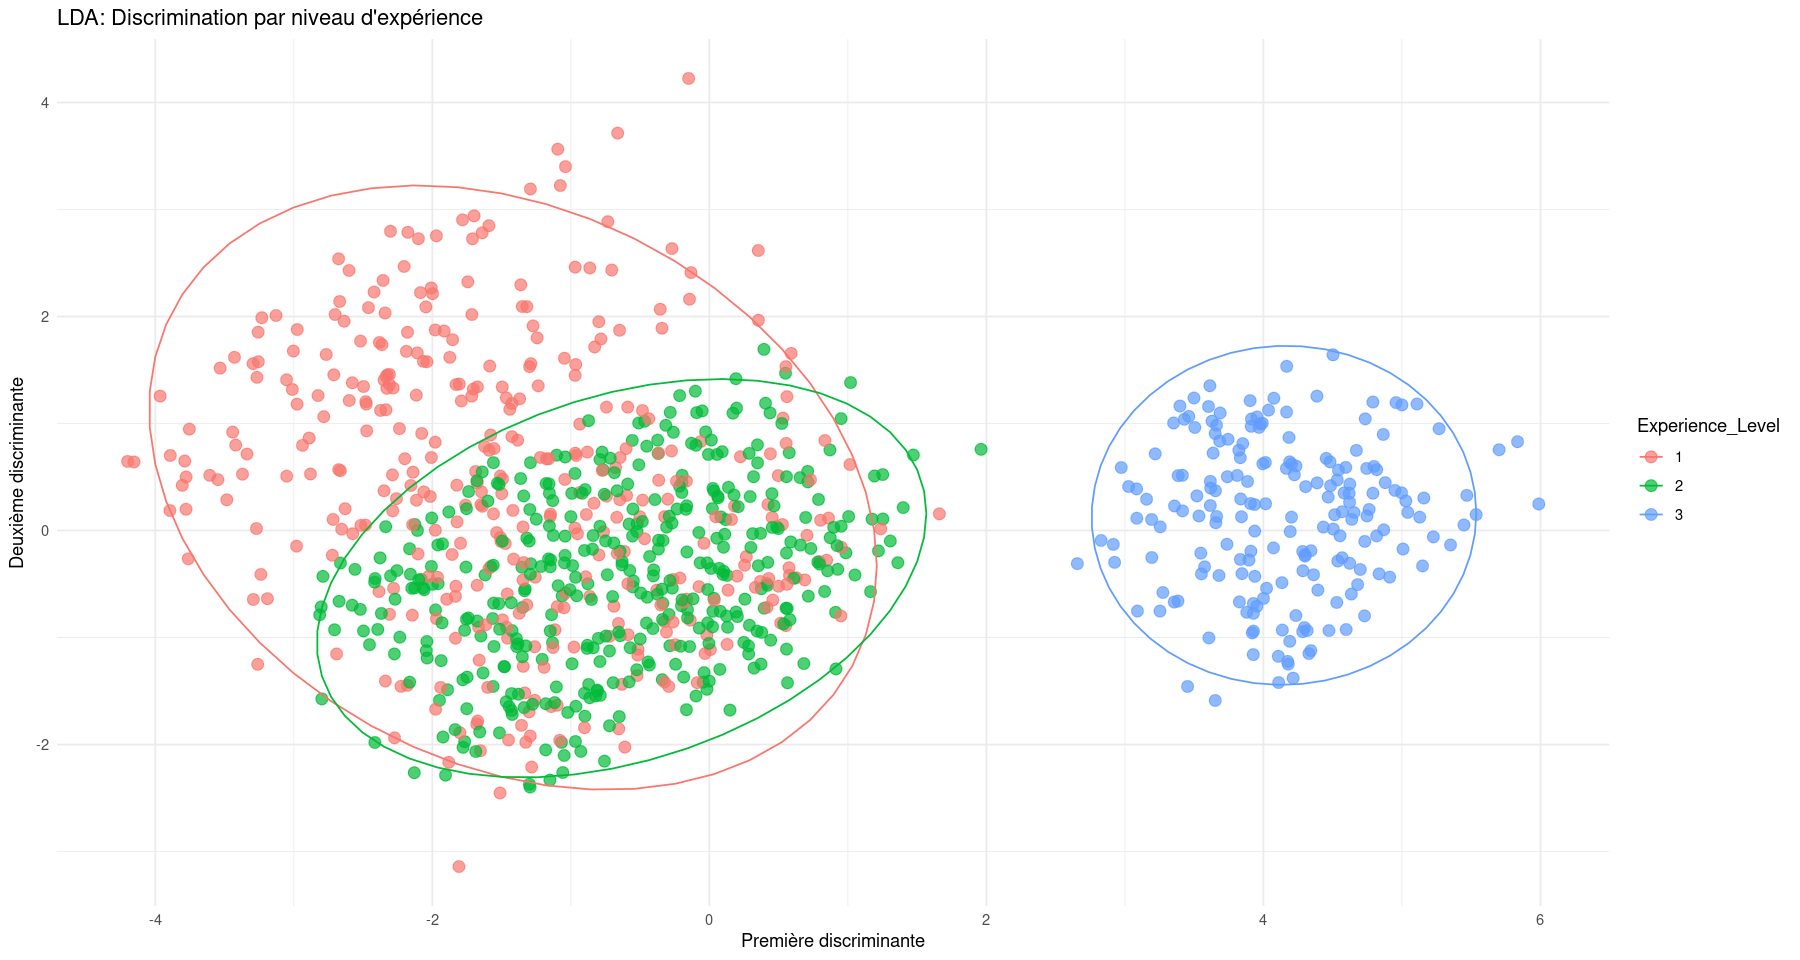

In [30]:
# Linear Discriminant Analysis
# Let's use Experience_Level as the target variable
library(MASS)

# Create a dataframe with the quantitative variables and the target variable
gym_lda_data <- cbind(gym_quanti, Experience_Level = gym$Experience_Level)

# Perform LDA
lda_result <- lda(Experience_Level ~ ., data = gym_lda_data)

# Summary of the LDA model
lda_result$scaling


# Create better visualization with ggplot2
lda_pred <- predict(lda_result, gym_lda_data)
lda_df <- data.frame(
    LD1 = lda_pred$x[,1],
    LD2 = lda_pred$x[,2],
    Experience_Level = gym_lda_data$Experience_Level
)

# Visualize the LDA results
ggplot(lda_df, aes(x = LD1, y = LD2, color = Experience_Level)) +
    geom_point(size = 3, alpha = 0.7) +
    stat_ellipse() +
    labs(title = "LDA: Discrimination par niveau d'expérience",
             x = "Première discriminante",
             y = "Deuxième discriminante") +
    theme_minimal()


#### Interpretation des résultats de la LDA sur Experience level: 
On observe du graphe que la LDA permet bien de séparer les Experts (3) sur l’axe LD1, car ils sont clairement décalés.
Mais elle a plus de mal entre Débutants (1) et Intermédiaires (2), qui se mélangent beaucoup.
LD1 (axe horizontal - Première discriminante) :

- C’est l’axe principal de séparation.
Variables qui contribuent le plus à LD1 :

    Session_Duration (7.6756) : plus la durée d'entraînement est grande, plus ça tire vers la droite (plutôt vers les Experts). Water_Intake..liters. (0.21): Un effet positif, indiquant que l'hydratation joue un rôle dans la différenciation des groupes. 
    Weight et Height (-1.6378): plus le poids et la taille sont faibles, plus LD1 augmente.

- Interprétation :
LD1 semble principalement différencier les individus en fonction de leur engagement dans l'entraînement : la durée des sessions est le facteur dominant, avec un lien secondaire avec la taille et le poids.
Les Experts sont plutôt des personnes :

    Qui font des séances plus longues.
    Qui ont un IMC plus élevé.
    Et qui sont peut-être plus “légers” (au sens du poids, vu le signe négatif, mais à vérifier avec les données).

LD2 (axe vertical - Deuxième discriminante) :

- C’est l’axe secondaire, qui affine la séparation (notamment entre classes 1 et 2). Variables qui contribuent le plus à LD2 :

   Water_Intake..liters. (0.59): Influence la séparation sur ce second axe, indiquant que l'hydratation pourrait différencier des groupes d'expérience.
    Session_Duration..hours. (0.85): Reste un facteur important, mais avec moins d’impact que sur LD1.
    Height..m. (-0.36): Influence négative, mais plus faible que sur LD1.

- Interprétation :
LD2 est plus influencé par l’hydratation et d'autres variables secondaires, suggérant un axe de distinction différent, peut-être lié à des habitudes physiologiques ou nutritionnelles.

In [38]:
head(gym_quanti)

,Age,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Fat_Percentage,Water_Intake..liters.
,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,56,88.3,1.71,180,157,60,1.69,1313,12.6,3.5
2,46,74.9,1.53,179,151,66,1.30,883,33.9,2.1
3,32,68.1,1.66,167,122,54,1.11,677,33.4,2.3
4,25,53.2,1.70,190,164,56,0.59,532,28.8,2.1
5,38,46.1,1.79,188,158,68,0.64,556,29.2,2.8
6,56,58.0,1.68,168,156,74,1.59,1116,15.5,2.7


### Clustering par Kmeans

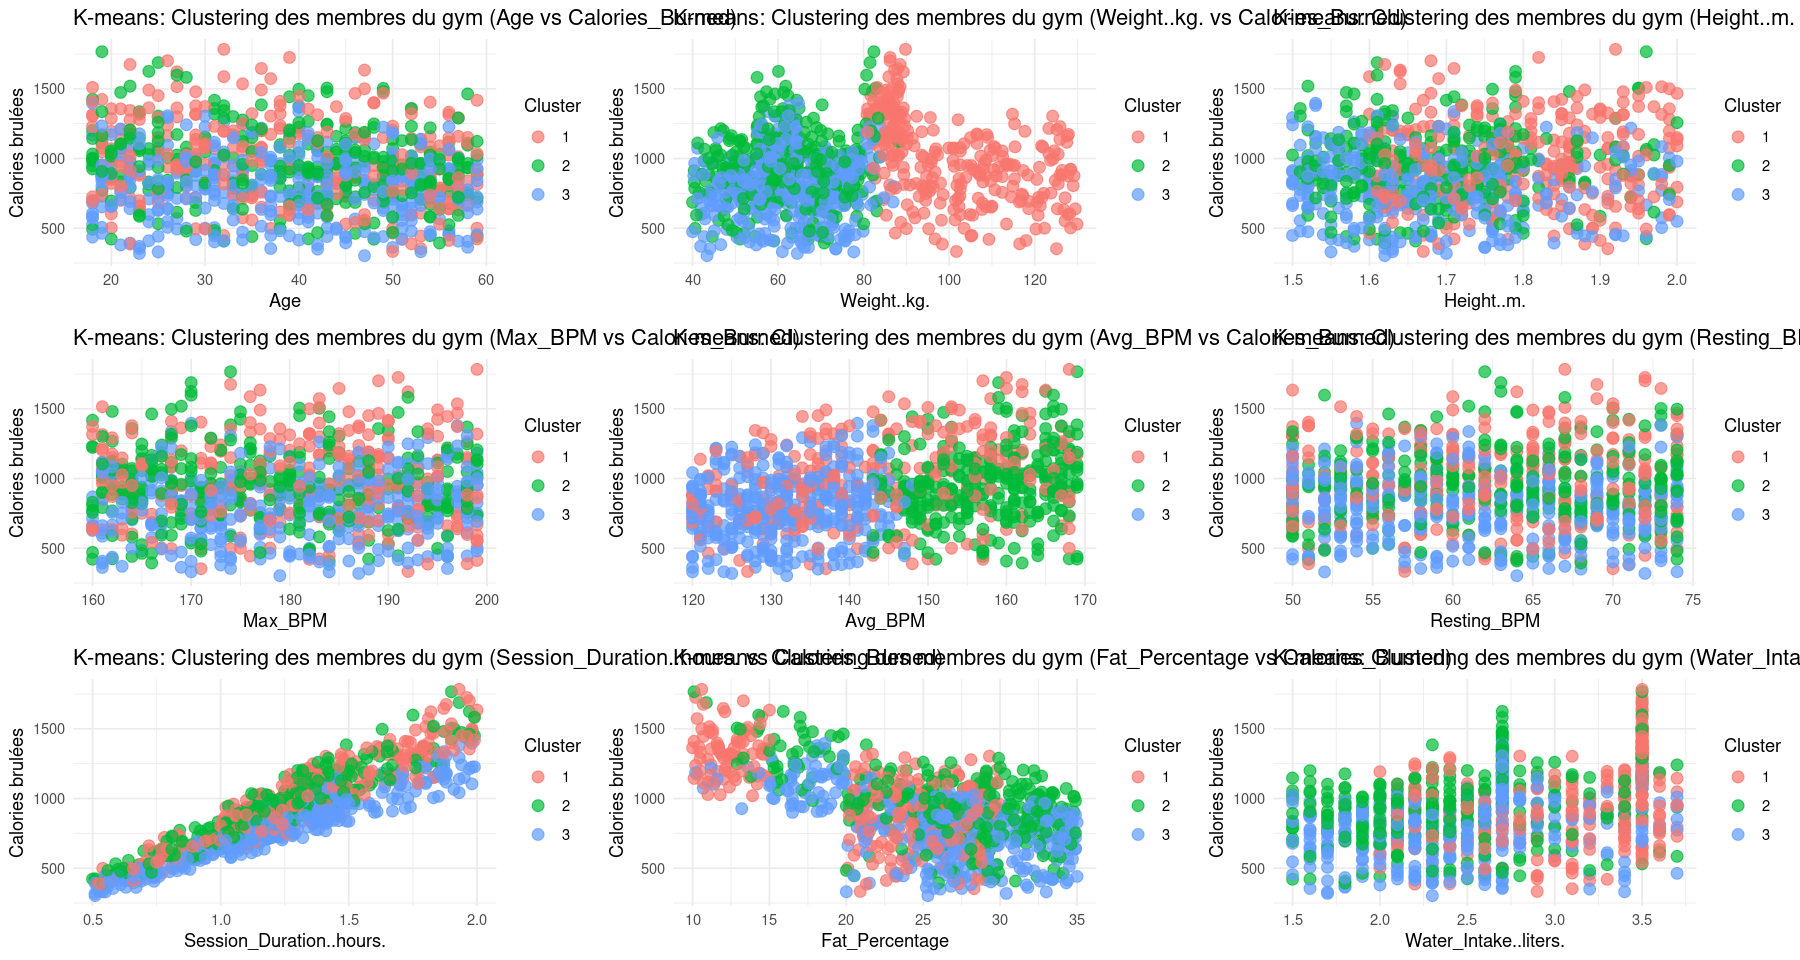

In [41]:
#kmeans clustering method with he gym data set with 3 clusters
#create a data set without calories burned
gym_quanti2 <- gym_quanti[, -8]
#head(gym_quanti2)
kmeans_result <- kmeans(gym_quanti2, centers = 3, nstart = 50)
#kmeans_result$cluster
#head(gym_quanti)
# Create a dataframe with the quantitative variables and the cluster variable
gym_kmeans_data <- cbind(gym_quanti, Cluster = as.factor(kmeans_result$cluster))



# Plot all clusters for y = Calories_Burned and x varies with all the variables
plot_list <- list()
for (var in names(gym_quanti2)) {
     p <- ggplot(gym_kmeans_data, aes_string(x = var , y = "Calories_Burned", color = "Cluster")) +
          geom_point(size = 3, alpha = 0.7) +
          labs(title = paste("K-means: Clustering des membres du gym (", var, " vs Calories_Burned)", sep = ""),
                x = var,
                y = "Calories brulées") +
          theme_minimal()
     plot_list[[var]] <- p
}

# Display all plots
do.call(grid.arrange, c(plot_list, ncol = 3))


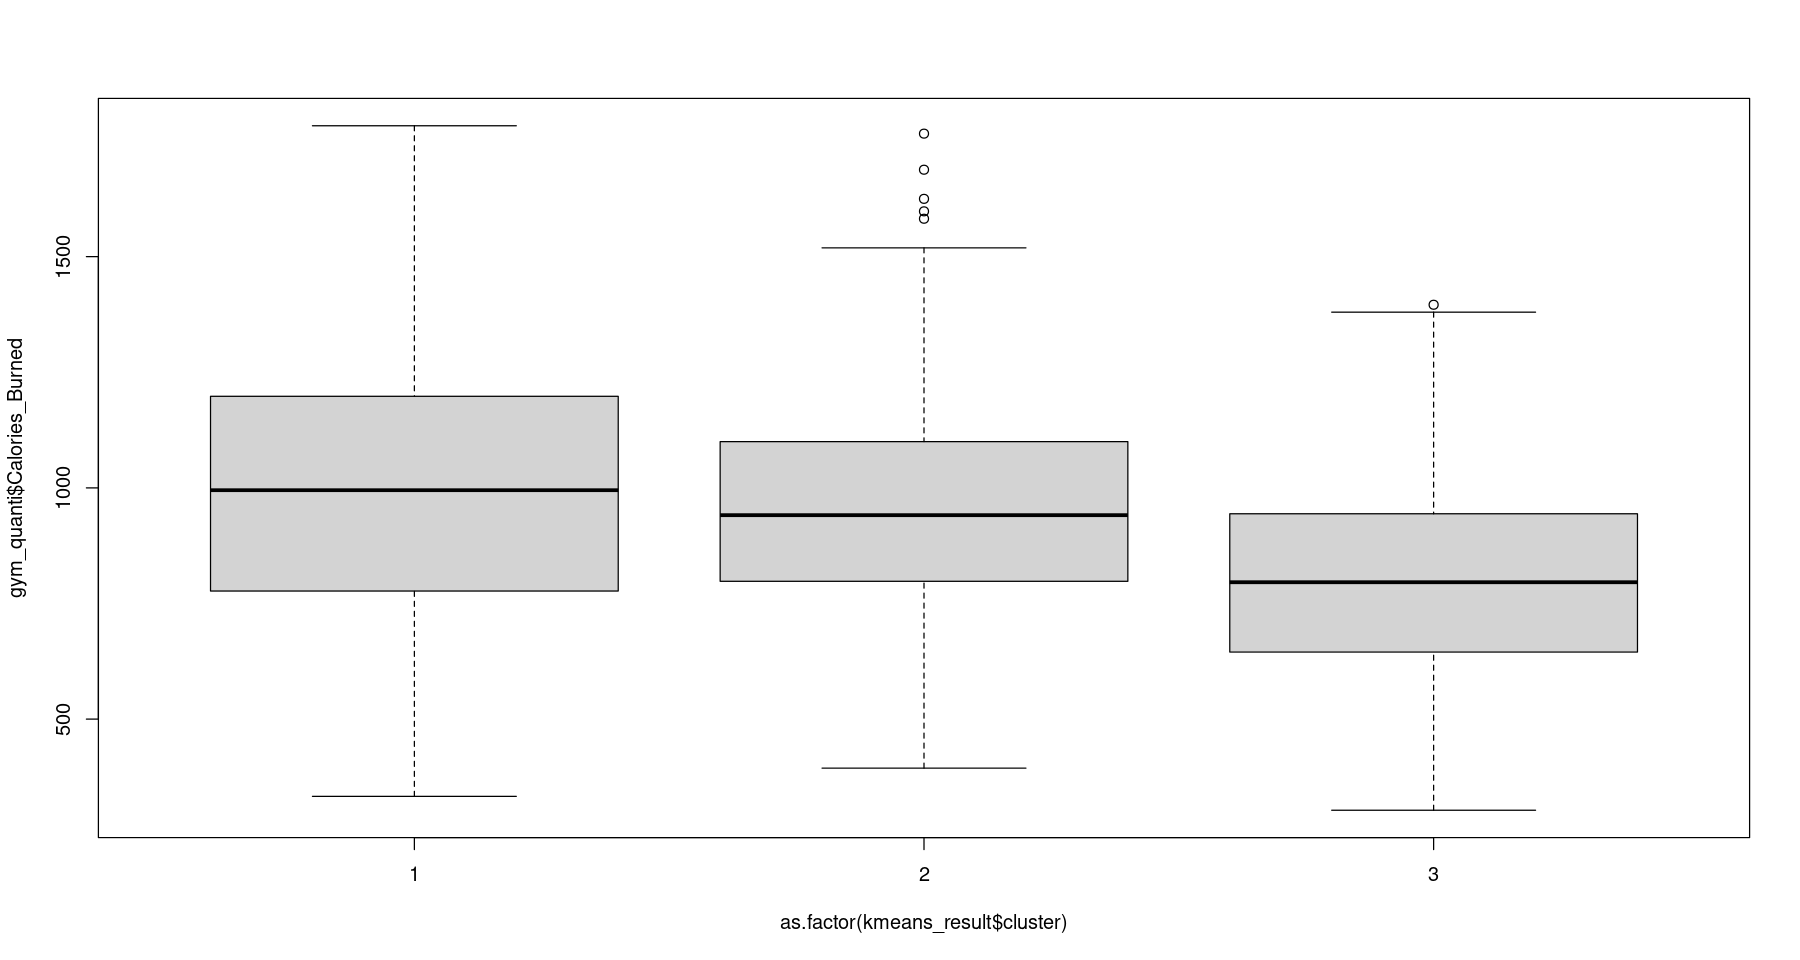

In [42]:
boxplot(gym_quanti$Calories_Burned~as.factor(kmeans_result$cluster))

on constate que . le cluster semble dependre uniquement de la valeure de calories burned, la variable session_duration est la seule qui présente un lien avec la variable calories burned et les clusters , à faire en enlevant calories burned pour faire les clusters 